# [Modelo] Segmentación K-Means

### Caso:

El caso consiste que, en los últimos años la guerra de ofertas en descuentos, afiliación, incentivación de consumo a sus clientes de las entidades bancarias ha crecido, y es muy común que a cada cliente le lleguen distintas ofertas a su correo electrónico o a su hogar.

El problema es: ¿qué tan interesado está el cliente en querer consumir lo que la entidad bancaria le ofrece?, recordemos que por debajo de un descuento ya existe un gasto para la empresa así lo consuma o no el cliente.

Por tanto, lo que se quiere solucionar es: ¿cómo identifico las preferencias de consumo de los clientes en base a las transacciones que realiza éste con su tarjeta de crédito y/o débito?


### Objetivo:
Desarrollar un modelo de segmentación y perfil de clientes,
en base al consumo de los clientes con su tajeta de crédito y débito.

## 1. Librerias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

## 2. Extracción Base de datos

In [ ]:
dataFrame = pd.read_csv("data/02dataBaseConsumo.txt",delimiter='|', encoding='latin-1')
print(dataFrame.head())

   codmes  cliente       edad      ingreso sexo  flgLimaProv  flgAfBxi  \
0  201611    32572  [1. <=25]  [2. <=1500]    F          1.0       1.0   
1  201611    29843  [1. <=25]  [3. <=2500]    F          0.0       1.0   
2  201611    30033  [2. <=30]  [2. <=1500]    F          0.0       1.0   
3  201612     3847  [7. > 55]  [3. <=2500]    M          1.0       0.0   
4  201611    33131  [1. <=25]  [2. <=1500]    F          1.0       1.0   

   grupoGiro  monto  trx  
0    restbar     12    1  
1  prodlocal     22    1  
2    restbar     10    1  
3    restbar    350    4  
4    restbar     65    2  


In [ ]:
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339476 entries, 0 to 339475
Data columns (total 10 columns):
codmes         339476 non-null int64
cliente        339476 non-null int64
edad           326477 non-null object
ingreso        308148 non-null object
sexo           327721 non-null object
flgLimaProv    327725 non-null float64
flgAfBxi       327725 non-null float64
grupoGiro      339476 non-null object
monto          339476 non-null int64
trx            339476 non-null int64
dtypes: float64(2), int64(4), object(4)
memory usage: 25.9+ MB


## 3. Metodología

In [ ]:
#### 3.1 Análisis Previo (objetivo)
#### 3.2 Exploración (descriptivo, grafico barras,cajas)
#### 3.3 Transformación (standarización,cajas)
#### 3.4 Outliers (analisis y eliminación de outliers)
#### 3.5 Dimensionamiento (PCA)
#### 3.6 Modelamiento
#### 3.7 Evaluación
#### 3.8 Perfilamiento

### 3.1 Análisis Previo¶

Realizaremos un análisis para saber cuáles son los rubros de consumo que se tienen. En la descripción del caso ya sabemos que son 21 pero no que rubros y cuales es el de mayor proporción en la base .

In [ ]:
# Creamos una copia de nuestra base.
copy = pd.DataFrame()
resumRubro = pd.DataFrame()

copy = dataFrame
resumRubro["ctdTrx"] = copy.groupby("grupoGiro").agg("trx").sum()

print('Cantidad de Rubros: '+str(resumRubro.shape[0]))
print('\n')
print(resumRubro.sort_values("ctdTrx",ascending=False))

Cantidad de Rubros: 22


                 ctdTrx
grupoGiro              
prodsuper        142313
restbar          103507
salud             63109
vehrep            45978
entretenimiento   43009
tiendadepar       37290
ropamoda          28205
prodpersondiv     15649
telcom            12606
financiero         9889
transplaerea       8992
clubmkt            8626
prodlocal          6966
enseñanza          5897
belleza            5445
prodelectro        4989
alqbienes          3528
artcultura         3307
profdiverso        2685
hogaroficina       1584
**                  255
informatica          89


## Nota:

Se tienen 22 rubros (Uno de estos corresponde a los valores en blanco o perdidos **). También se puede observar que el mayor número de transacciones están entre los rubros Supermercados, restaurantes y bares, Salud y Repuestos para vehículos. Y los de menor transaccionalidad fueron informática, Hogar y oficina.

Veamos graficamente nuestros datos para tener una idea de su dispersión:

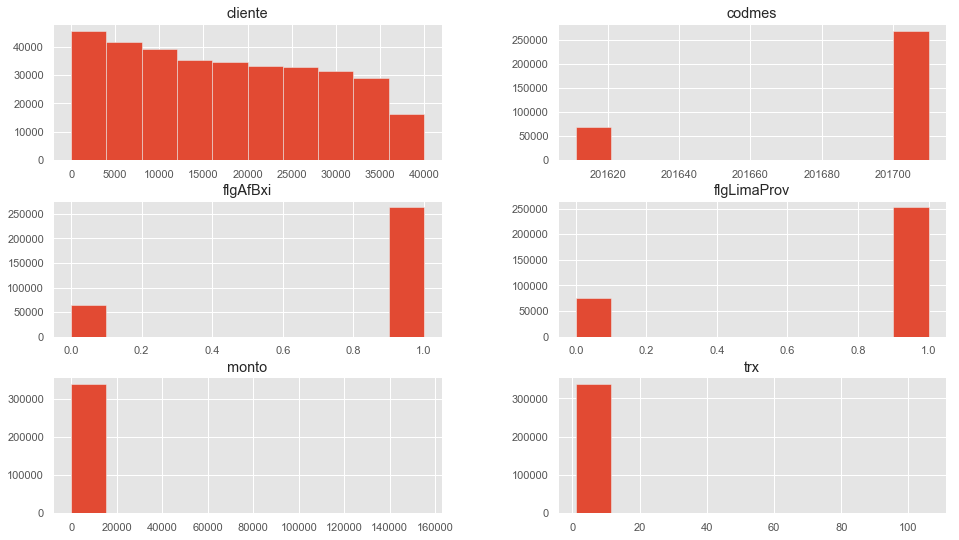

In [ ]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

#Veremos la dispersión de nuestros datos
dataFrame.drop(['grupoGiro'],1).hist()
plt.show()

Para la variable txr podemos observar que el mayor número de transacciones están concentradas entre 1 y 20 trx y para la variable monto este se puede observar de 0 hasta 20mil (lo ideal es mejorar la escala en este cao para ver mayor detalle).

Para el gráfico a continuación consideraremos las variables monto y trx y las cruzaremos con los diferentes rubros para ver si nos dan alguna pista de su agrupación.

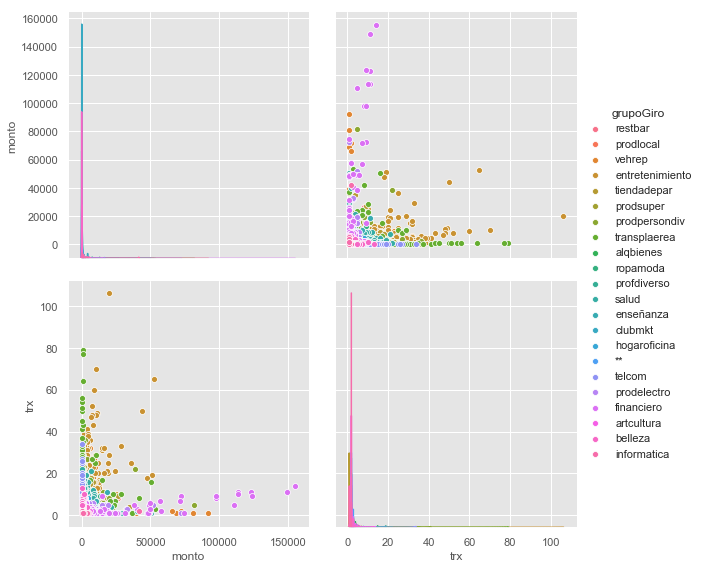

In [ ]:
#Relaciones
r= sns.pairplot(dataFrame.dropna(), hue='grupoGiro',height=4, vars=["monto", "trx"], kind='scatter')
r

Se quiere realizar una segmentación y perfilamiento de cliente según su consumo realizado con tarjeta de crédito o débito.  Antes de realizaremos tratamiento o gestión de la data para ver comportamiento o distribución de estos.

Buscaremos obtener el número de clientes, el total de transacciones y el número de transacciones promedio por cliente según los periodos en donde se realizó el consumo.

In [ ]:
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['ctdCliente'] = copy.groupby('codmes').agg('cliente').nunique()
cantidadGrupo['ctdTrx']= copy.groupby('codmes').agg('trx').sum()
cantidadGrupo['promTrxCli'] = round(cantidadGrupo['ctdTrx']/cantidadGrupo['ctdCliente'],2)
cantidadGrupo.head()

,ctdCliente,ctdTrx,promTrxCli
codmes,,,
201611,13641,48494,3.56
201612,16034,68542,4.27
201701,14215,52089,3.66
201702,13726,47275,3.44
201703,13822,48331,3.50


Para tener una idea del comportamiento de los datos los veremos graficamente:

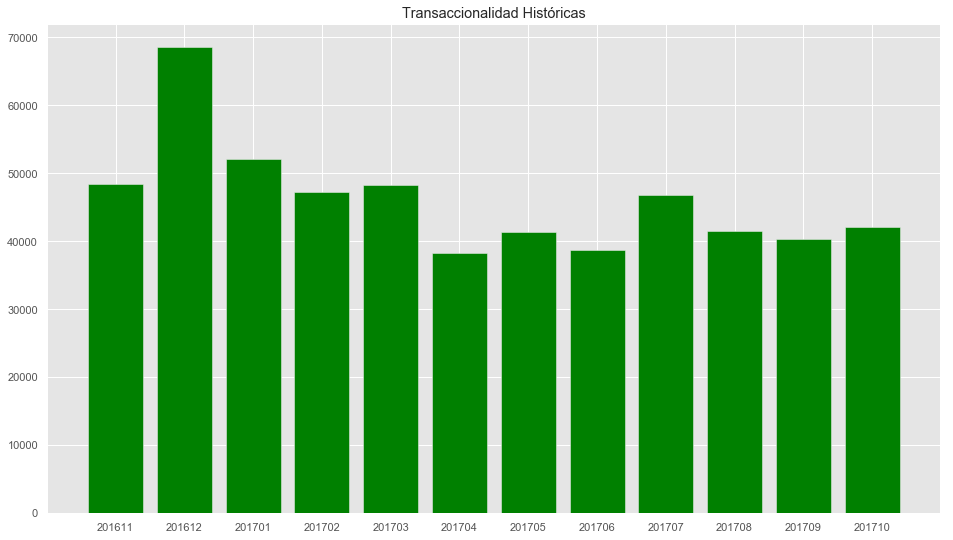

In [ ]:
# Transaccional Históricas
fig = plt.figure() # Figure
ax = fig.add_subplot(111) # Axes

plt.bar(range(len(cantidadGrupo.index)),cantidadGrupo['ctdTrx'],color='GREEN')
plt.title('Transaccionalidad Históricas')
ax.set_xticks(range(len(cantidadGrupo.index)))
ax.set_xticklabels(cantidadGrupo.index)
plt.show()

Según el gráfico se puede observar que el mayor número de transacciones se está concentrada en mes de diciembre de 2016.

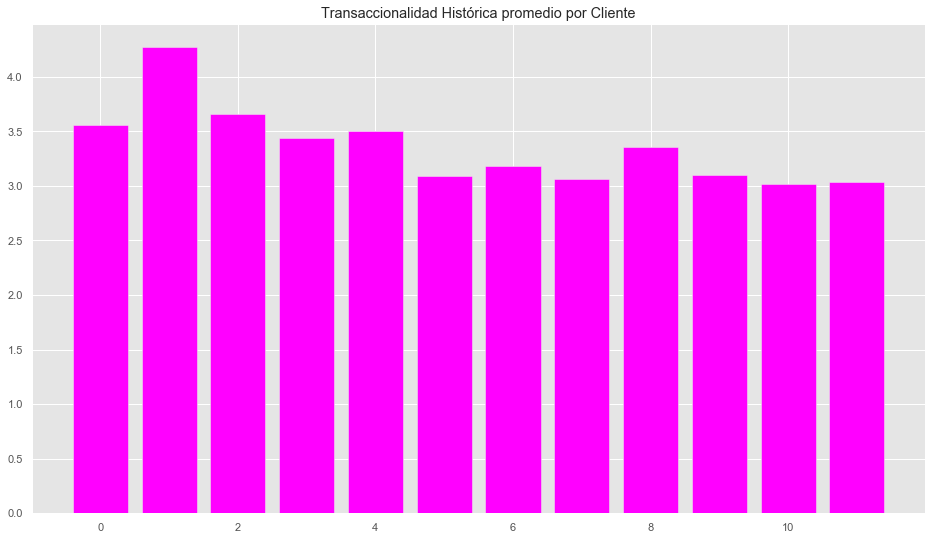

In [ ]:
# Transaccionalidad historica promedio por Cliente.
plt.bar(range(len(cantidadGrupo.index)),cantidadGrupo['promTrxCli'],color='MAGENTA')
plt.title('Transaccionalidad Histórica promedio por Cliente')
ax.set_xticks(range(len(cantidadGrupo.index)))
ax.set_xticklabels(cantidadGrupo.index)
plt.show()

El mayor número de operaciones promedios según el gráfico se puede observar en 1, lo que nos indica que almenos una operacion en promedio es realizada por los clientes.

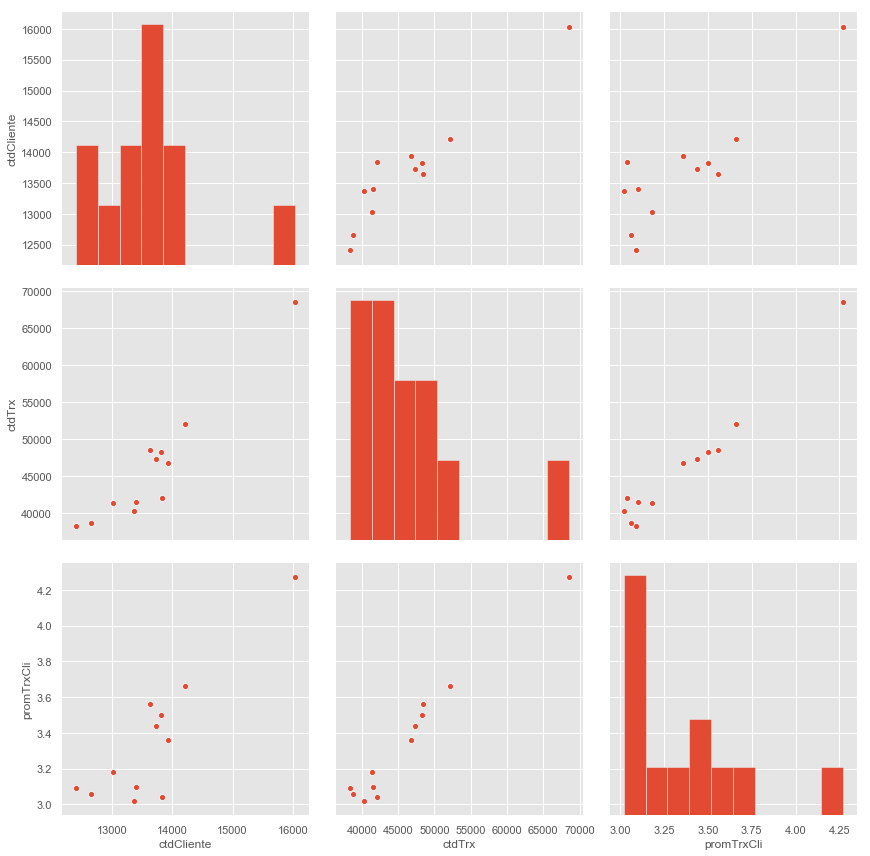

In [ ]:
x= sns.pairplot(cantidadGrupo.dropna(),height=4, vars=["ctdCliente", "ctdTrx","promTrxCli"], kind='scatter')
x

In [ ]:
#Buscaremos tener por cliente la frecuencia de compra o transaccionalidad
cantidadGrupo  =  pd.DataFrame()
cantidadGrupo2 =  pd.DataFrame()

cantidadGrupo['frecMeses'] = copy.groupby('cliente').agg('codmes').nunique()
cantidadGrupo['sumTrx'] = copy.groupby('cliente').agg('trx').sum()
cantidadGrupo.head()

,frecMeses,sumTrx
cliente,,
1,10,38
2,10,58
3,12,42
4,12,167
5,3,3


In [ ]:
# Buscaremos sacar por mes consumido el número de clientes y sus transaciones.
cantidadGrupo2 =  pd.DataFrame()
cantidadGrupo2['ctdCliente'] = cantidadGrupo.groupby('frecMeses').size()
cantidadGrupo2['ctdTrx'] = cantidadGrupo.groupby('frecMeses').agg('sumTrx').sum()
cantidadGrupo2.head()

,ctdCliente,ctdTrx
frecMeses,,
1,11461,20497
2,6626,30243
3,4578,33569
4,3437,36978
5,2702,37495


In [ ]:
#Buscaremos sacar el número de transacciones y el promedio de transacciones por cliente según la frecuencia del mes
#donde realizaron consumo.

cantidadGrupo2['ctdTrxMes'] = round(cantidadGrupo2['ctdTrx']/cantidadGrupo2.index,2)
cantidadGrupo2['promTrxCli'] = round(cantidadGrupo2['ctdTrxMes']/cantidadGrupo2['ctdCliente'],2)
cantidadGrupo2

,ctdCliente,ctdTrx,ctdTrxMes,promTrxCli
frecMeses,,,,
1,11461,20497,20497.00,1.79
2,6626,30243,15121.50,2.28
3,4578,33569,11189.67,2.44
4,3437,36978,9244.50,2.69
5,2702,37495,7499.00,2.78
6,2176,39250,6541.67,3.01
7,1773,39623,5660.43,3.19
8,1584,41168,5146.00,3.25
9,1310,40729,4525.44,3.45


Lo que buscamos con esto es darle los mismos pesos a cada una de las variables que tenemos o quitar el efecto en la base que puedan tener las variables con valores extremos o muy diferentes al resto.

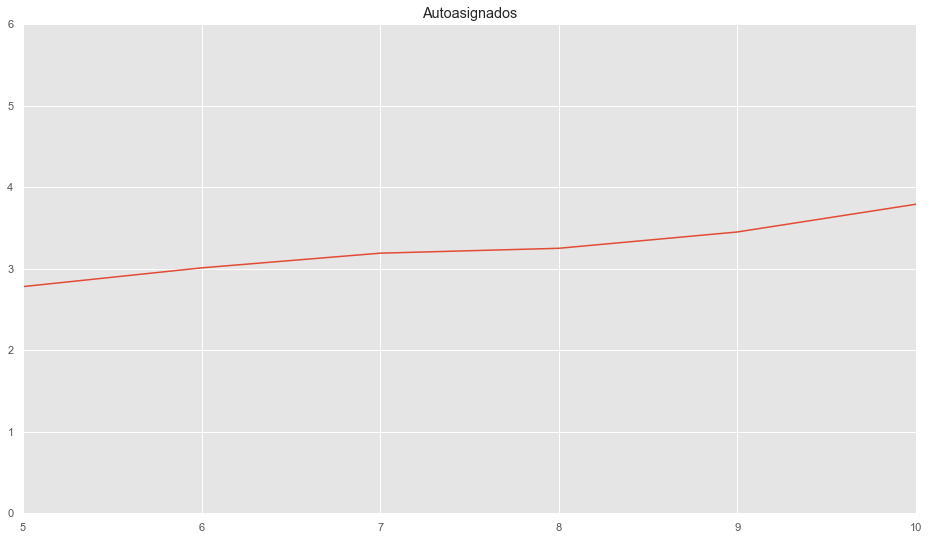

           ctdCliente  ctdTrx  ctdTrxMes  promTrxCli
frecMeses                                           
1               11461   20497   20497.00        1.79
2                6626   30243   15121.50        2.28
3                4578   33569   11189.67        2.44
4                3437   36978    9244.50        2.69
5                2702   37495    7499.00        2.78
6                2176   39250    6541.67        3.01
7                1773   39623    5660.43        3.19
8                1584   41168    5146.00        3.25
9                1310   40729    4525.44        3.45
10               1281   48600    4860.00        3.79
11               1249   58841    5349.18        4.28
12               1823  126925   10577.08        5.80


In [ ]:
# Gráfico de Líneas:
plt.plot(cantidadGrupo2['promTrxCli'])
plt.xlim(5,10)
plt.ylim(0,6)
plt.title('Autoasignados')
plt.show()
print(cantidadGrupo2)

Luego del análisis de datos con respecto a la transaccionalidad historia de los clientes, realizaremos la gestión de la data para obtener nuestra Matriz de Segmentación. Buscaremos llevar nuestra base a nivel de cliente y tener cada uno de nuestros rubros en distintas variables.

## Gestión de Data

In [ ]:
# Gestión de base para segmentación
copy=dataFrame
dataFrame = pd.DataFrame()

dataFrame['trxGrupoGiro']=copy.groupby(["cliente","grupoGiro","edad","ingreso","sexo"]).agg("trx").sum()
dataFrame = pd.pivot_table(dataFrame,'trxGrupoGiro',['cliente',"edad","ingreso","sexo"],'grupoGiro')
dataFrame = dataFrame.fillna(0)
dataFrame.head(10)

,,,grupoGiro,**,alqbienes,artcultura,belleza,clubmkt,enseñanza,entretenimiento,financiero,hogaroficina,informatica,prodelectro,prodlocal,prodpersondiv,prodsuper,profdiverso,restbar,ropamoda,salud,telcom,tiendadepar,transplaerea,vehrep
cliente,edad,ingreso,sexo,,,,,,,,,,,,,,,,,,,,,,
1,[7. > 55],[3. <=2500],M,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,7.0,2.0,3.0,0.0,2.0,0.0,10.0
2,[7. > 55],[8. > 8000],M,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,12.0,0.0,33.0,4.0,3.0,0.0,2.0,0.0,0.0
3,[7. > 55],[4. <=3500],M,0.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,11.0,5.0,7.0,1.0,0.0,0.0,8.0
4,[7. > 55],[6. <=6000],M,0.0,0.0,0.0,0.0,0.0,0.0,3.0,19.0,0.0,0.0,0.0,2.0,2.0,27.0,1.0,3.0,0.0,0.0,9.0,1.0,0.0,100.0
5,[7. > 55],[6. <=6000],M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,[7. > 55],[3. <=2500],M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,5.0
7,[7. > 55],[8. > 8000],M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
8,[7. > 55],[8. > 8000],M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0,2.0
9,[7. > 55],[4. <=3500],F,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,13.0,0.0,3.0,1.0,7.0,0.0,17.0,0.0,0.0


In [ ]:
dataFrame = dataFrame.reset_index()
cantidadGrupo = cantidadGrupo.reset_index()

dataFrame["frecMeses"] = cantidadGrupo["frecMeses"]

# Eliminando los valores autoasignados por no ser estables:
dataFrame = dataFrame[dataFrame["frecMeses"]>=5]
dataFrame = dataFrame[dataFrame["frecMeses"]<=10]
print(dataFrame.head())

grupoGiro  cliente       edad      ingreso sexo   **  alqbienes  artcultura  \
0                1  [7. > 55]  [3. <=2500]    M  0.0        1.0         0.0   
1                2  [7. > 55]  [8. > 8000]    M  0.0        0.0         0.0   
5                6  [7. > 55]  [3. <=2500]    M  0.0        0.0         0.0   
8                9  [7. > 55]  [4. <=3500]    F  0.0        0.0         0.0   
10              11  [7. > 55]  [4. <=3500]    M  0.0        0.0         0.0   

grupoGiro  belleza  clubmkt  enseñanza  entretenimiento  financiero  \
0              2.0      0.0        0.0              0.0         0.0   
1              0.0      0.0        1.0              0.0         0.0   
5              0.0      0.0        0.0              0.0         0.0   
8              1.0      0.0        0.0              0.0         0.0   
10             0.0      0.0        0.0              0.0         1.0   

grupoGiro  hogaroficina  informatica  prodelectro  prodlocal  prodpersondiv  \
0                  

In [ ]:
# Variables objetivo de estudio:
rubroName = ['prodsuper', 'restbar', 'salud', 'vehrep', 'entretenimiento', 'tiendadepar', 'ropamoda', 'prodpersondiv',
               'telcom','financiero', 'transplaerea','clubmkt','prodlocal','enseñanza','belleza','prodelectro',
               'alqbienes','artcultura','profdiverso','hogaroficina','informatica','**']

In [ ]:
print("Número de filas: " + str(dataFrame.shape[0]))
print("Número de columnas: " + str(dataFrame.shape[1]))

Número de filas: 10140
Número de columnas: 27


#### 3.2 Exploración de los Datos

In [ ]:
print(dataFrame[rubroName].describe())

grupoGiro     prodsuper       restbar         salud        vehrep  \
count      10140.000000  10140.000000  10140.000000  10140.000000   
mean           3.691716      2.549606      1.632051      1.216765   
std            9.258069      5.504099      4.682462      6.440480   
min            0.000000      0.000000      0.000000      0.000000   
25%            0.000000      0.000000      0.000000      0.000000   
50%            1.000000      1.000000      0.000000      0.000000   
75%            3.000000      3.000000      1.000000      0.000000   
max          229.000000     88.000000    102.000000    261.000000   

grupoGiro  entretenimiento   tiendadepar      ropamoda  prodpersondiv  \
count         10140.000000  10140.000000  10140.000000   10140.000000   
mean              1.203550      0.973274      0.719428       0.394280   
std               6.907515      2.481249      1.763253       1.644859   
min               0.000000      0.000000      0.000000       0.000000   
25%          

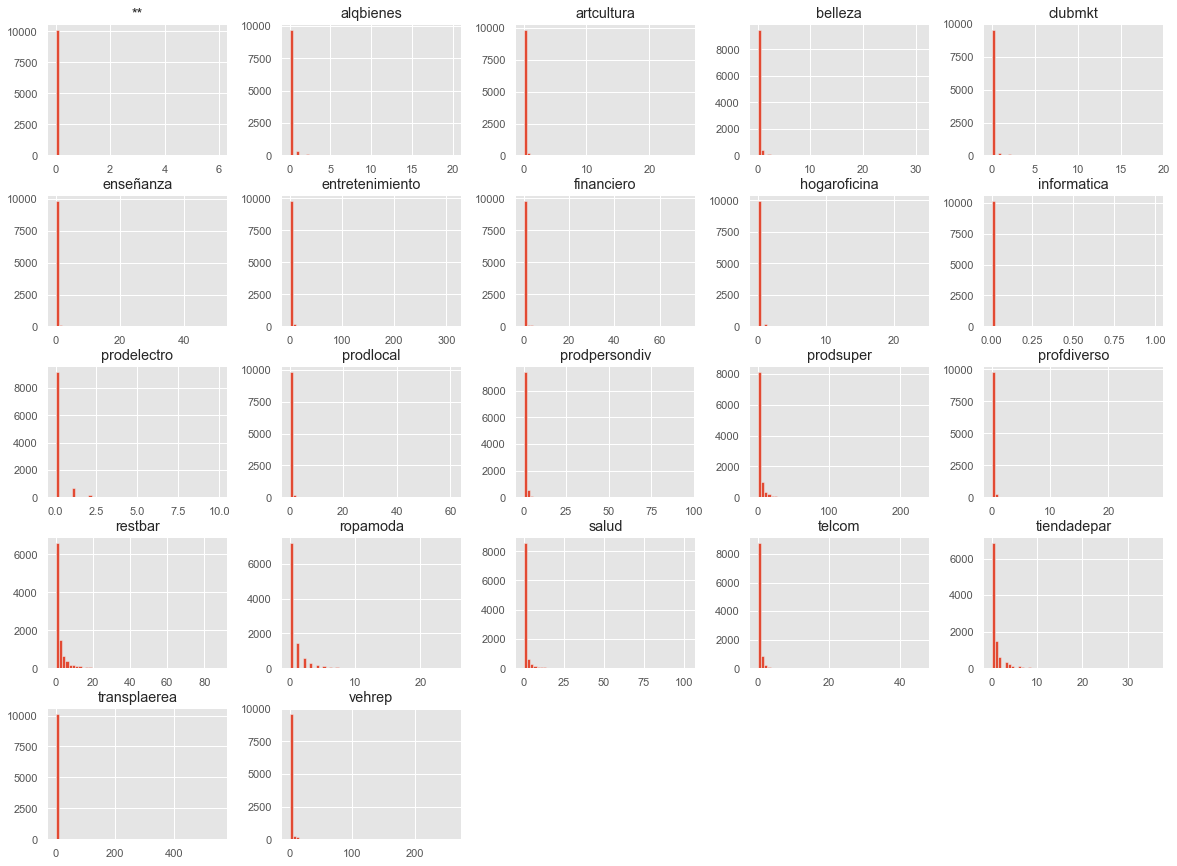

In [ ]:
dataFrame[rubroName].hist(bins = 50, figsize=(20,15))
plt.show()

Según los gráficos se puede observar que la mayoría de los datos para cada uno de los rubros a los que se está estudiando tienen una asimetría o sesgo positivo. Lo que nos puede indicar la presencia de datos atípicos o ausencia de datos en algunas variables.

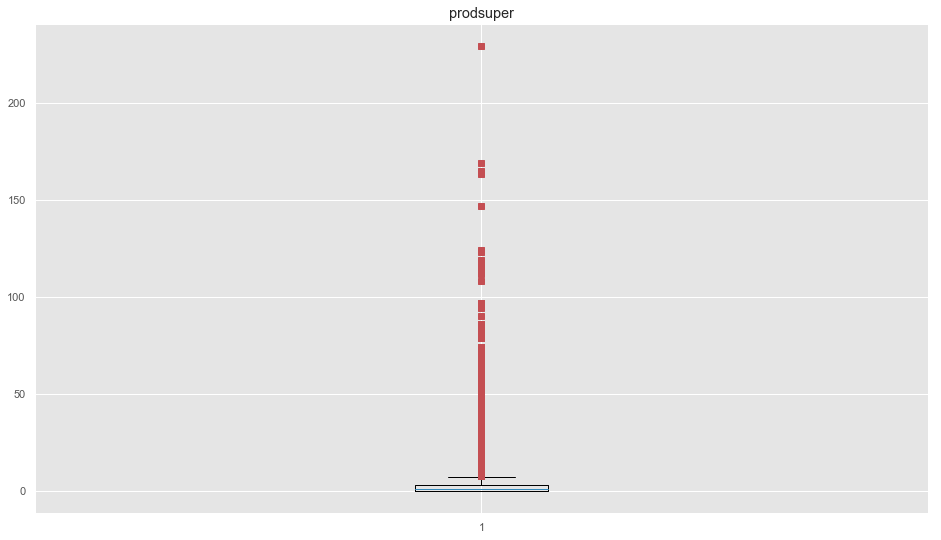

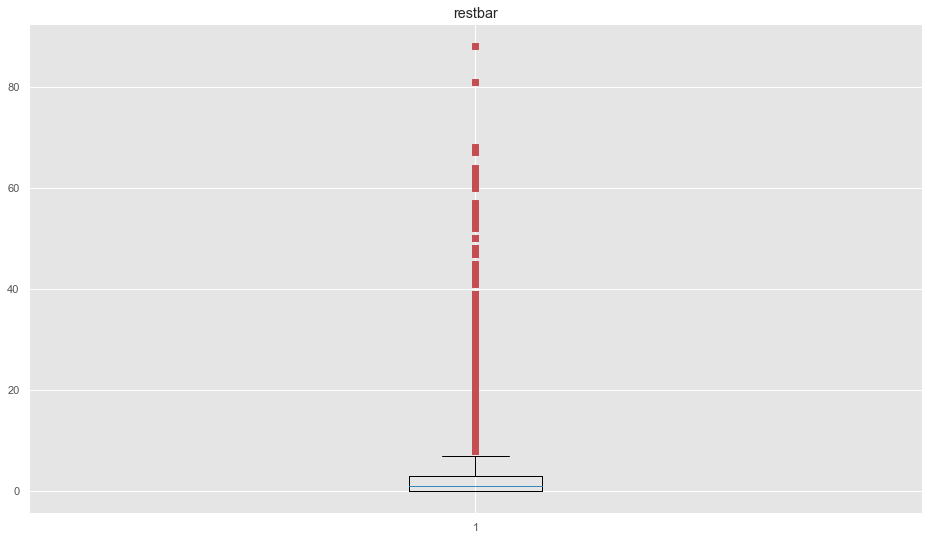

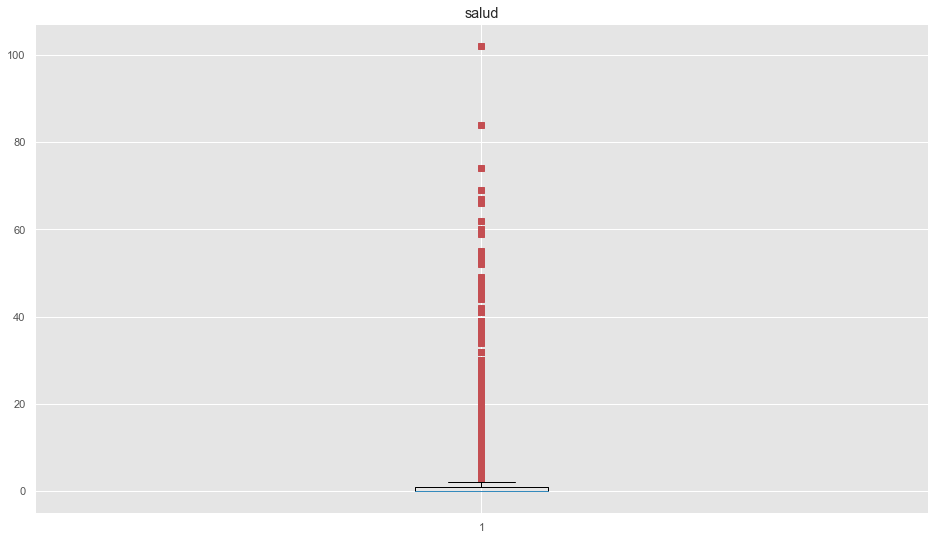

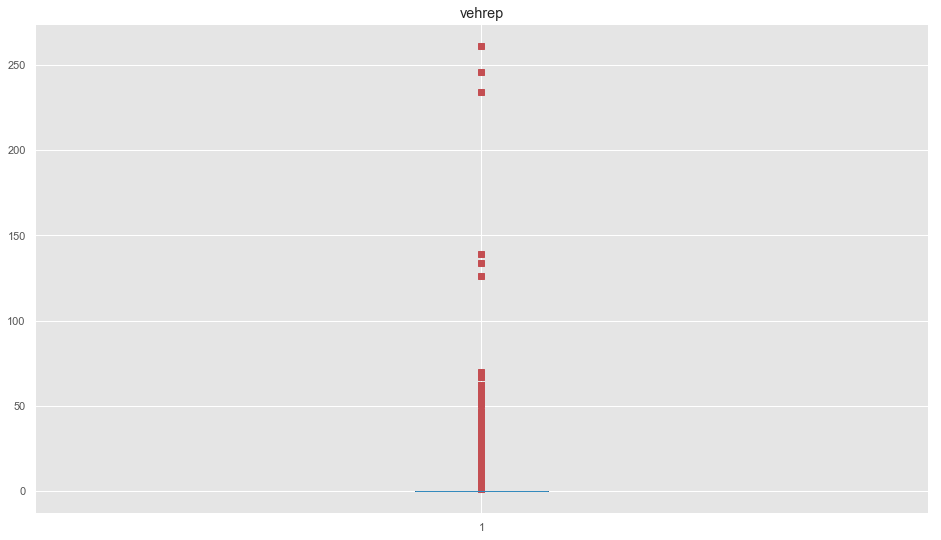

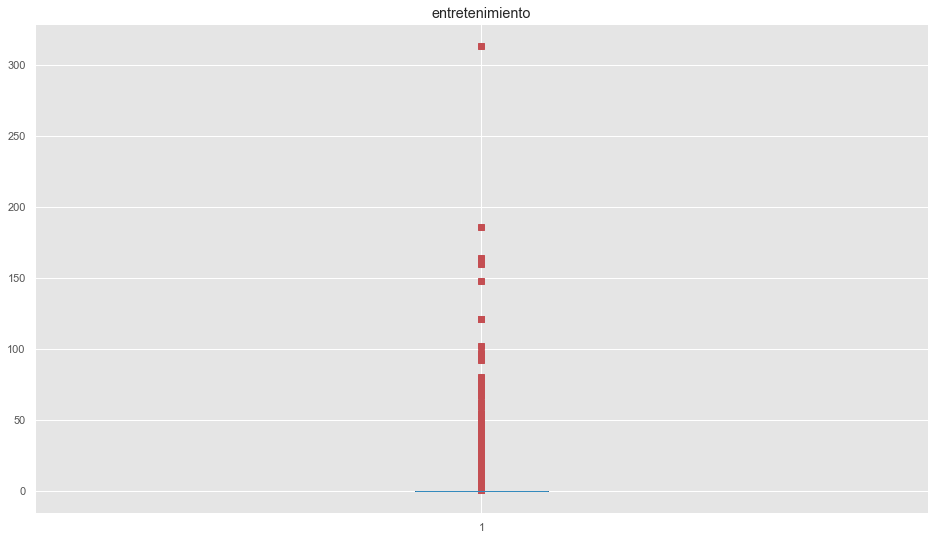

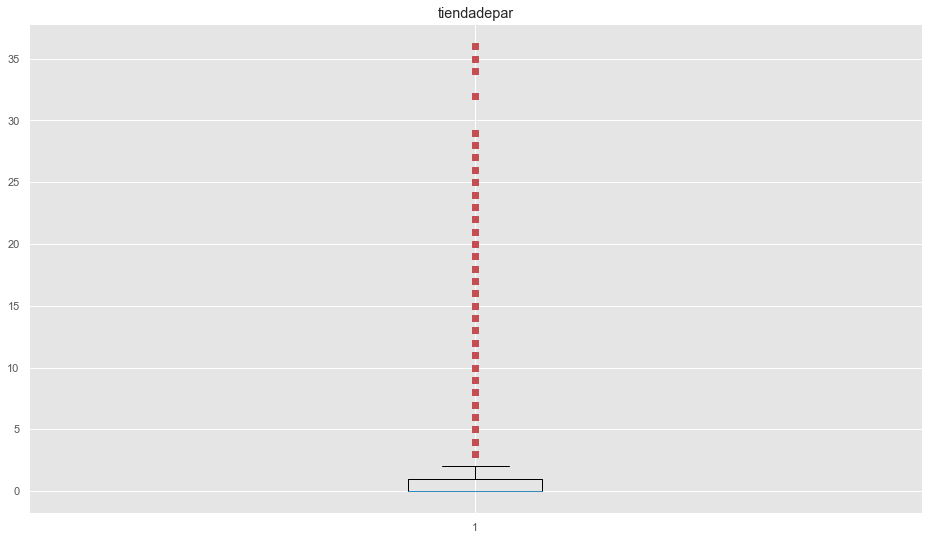

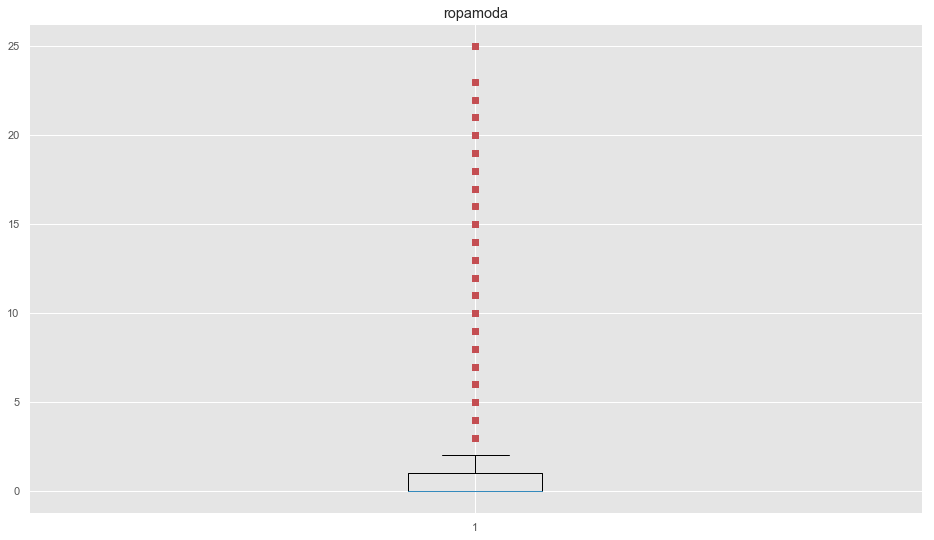

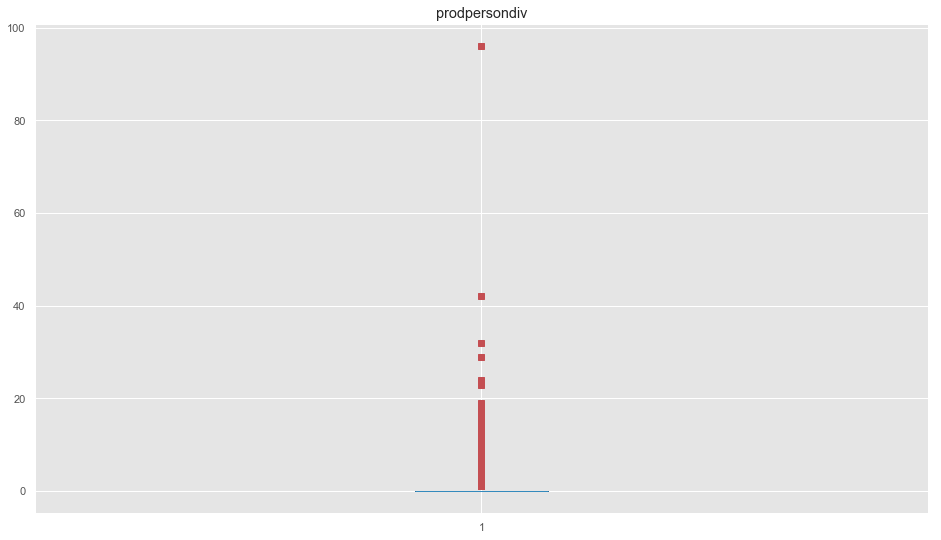

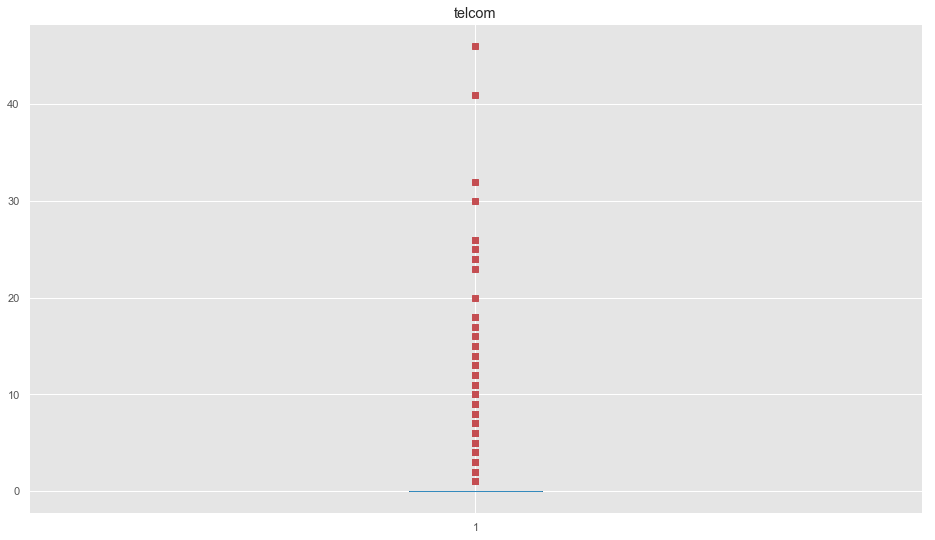

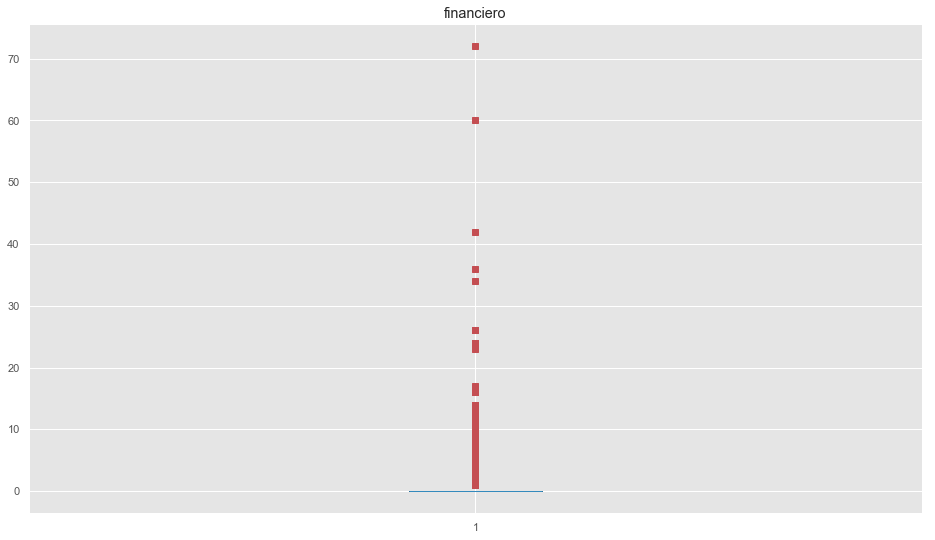

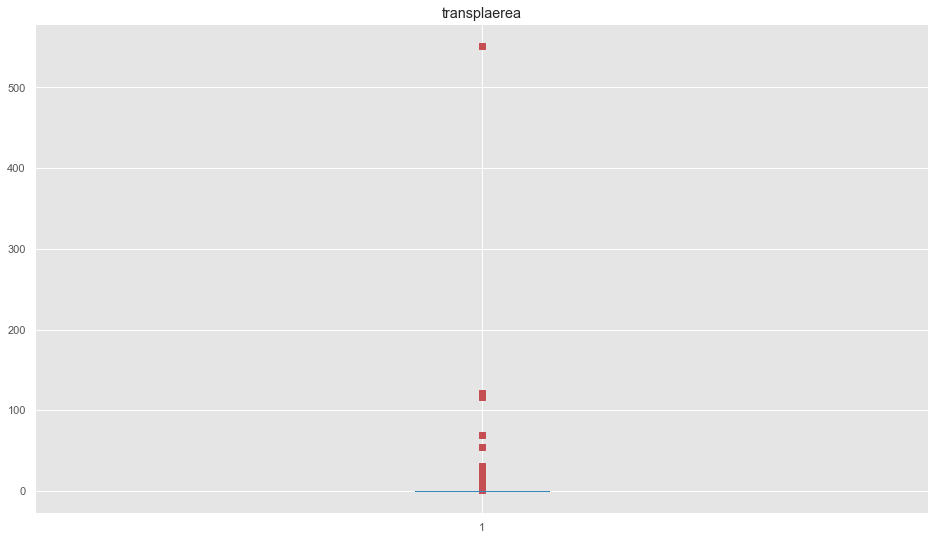

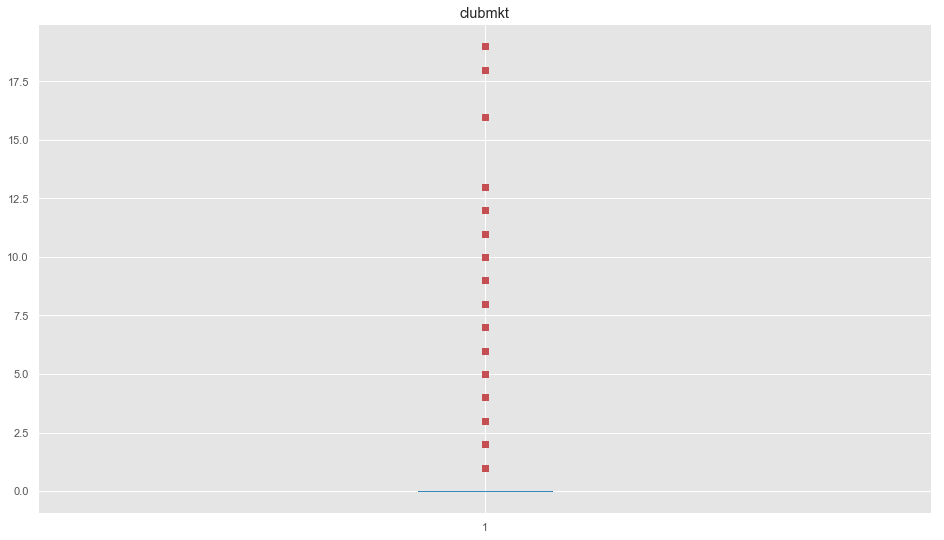

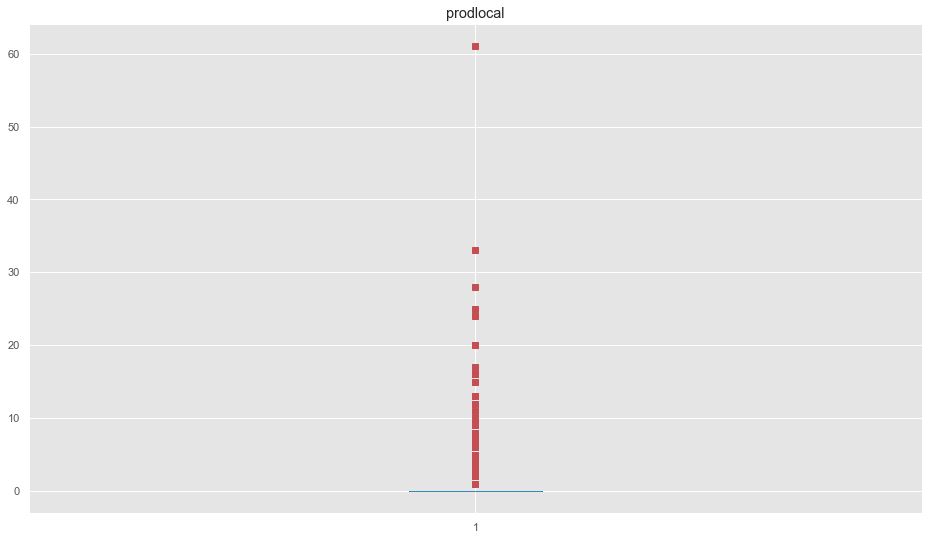

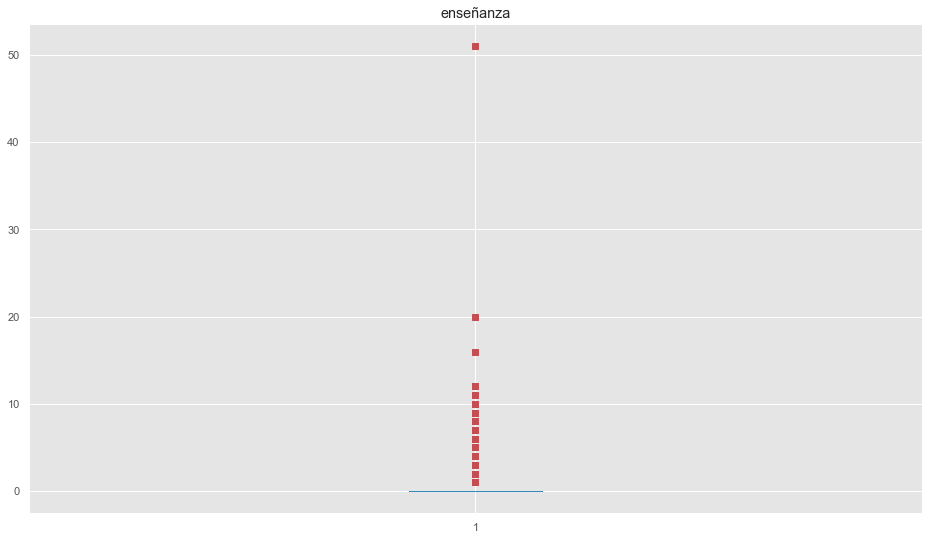

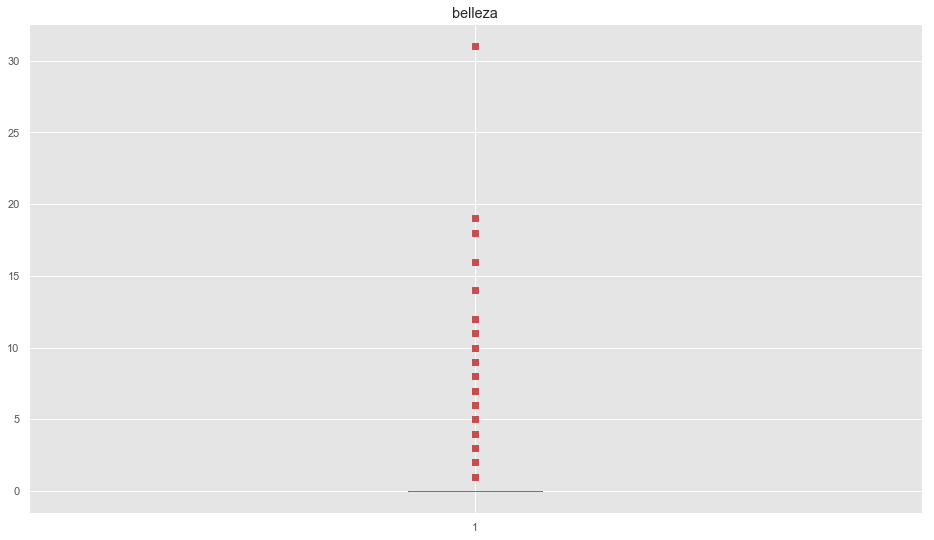

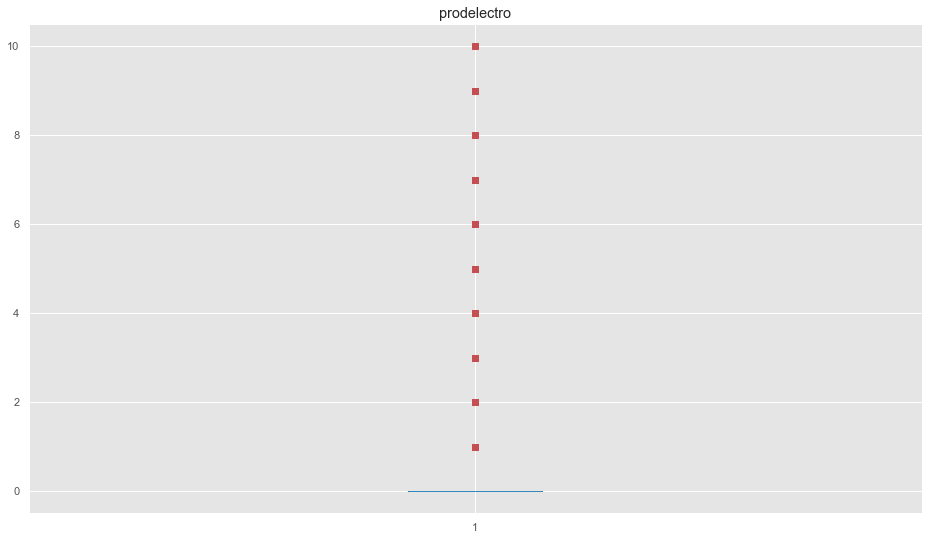

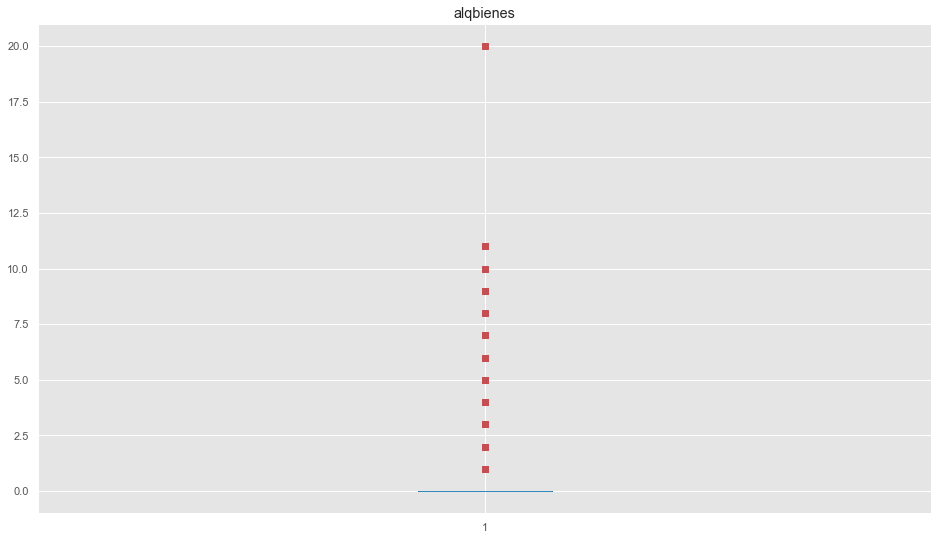

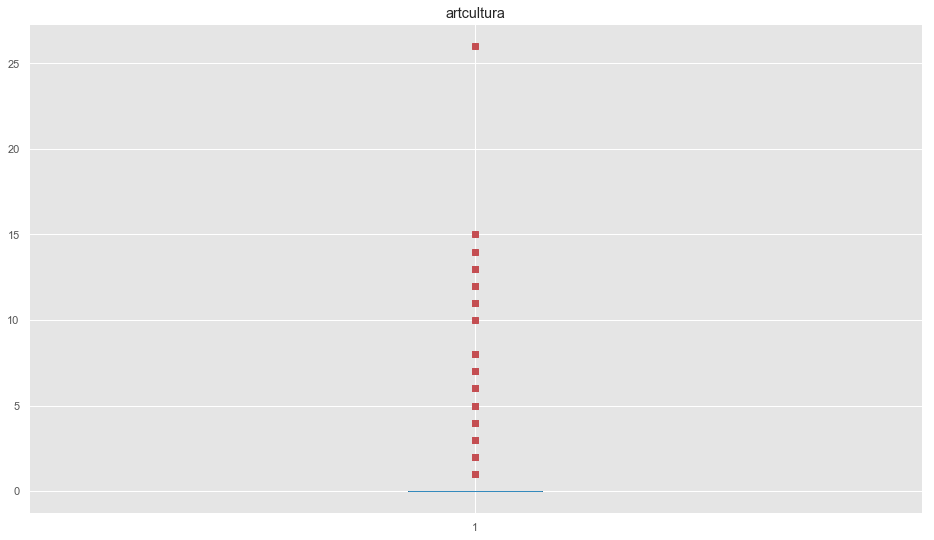

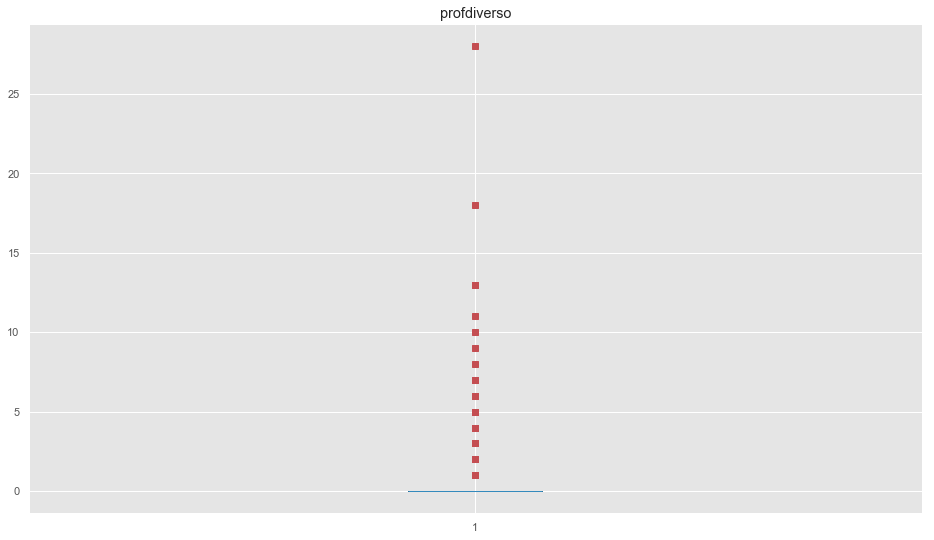

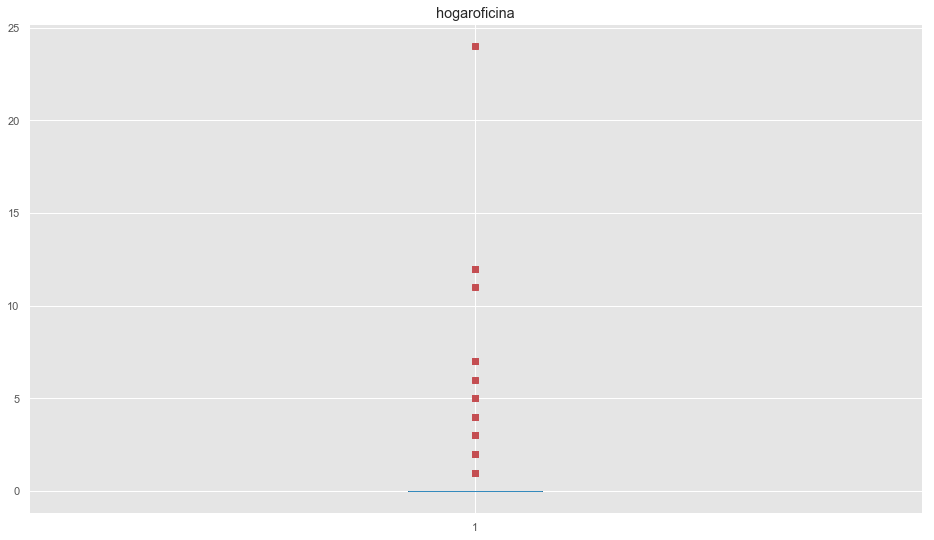

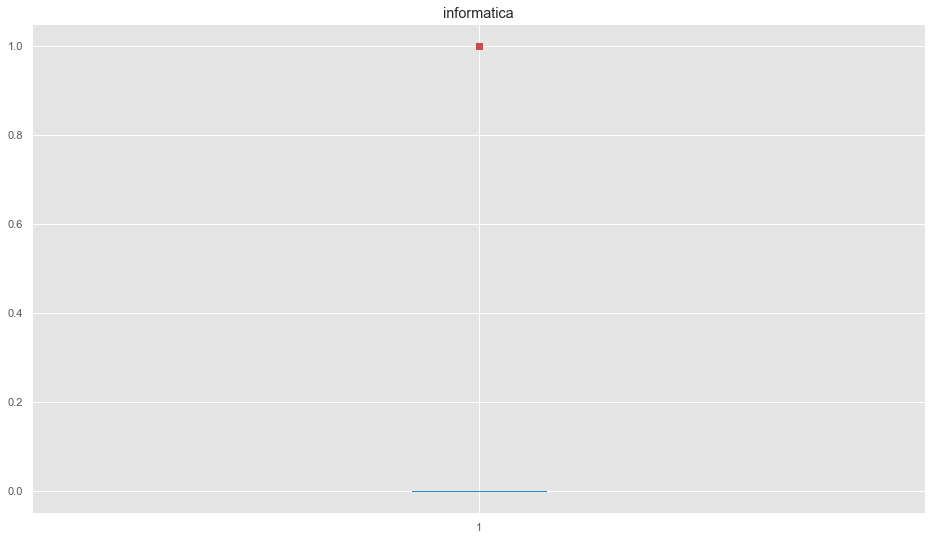

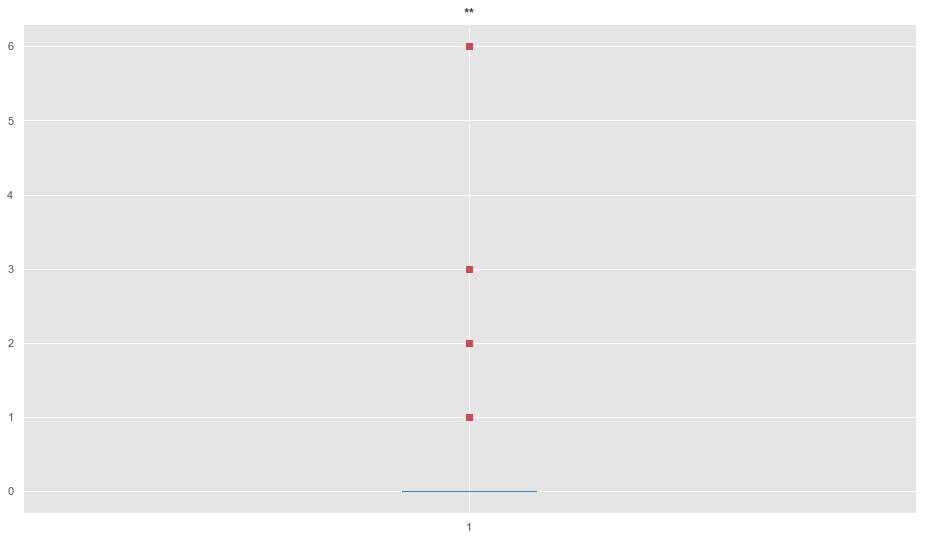

In [ ]:
# Gráfico de cajas por variable en estudio:
for columnName in rubroName:
    plt.title(columnName)
    plt.boxplot(dataFrame[columnName], 0, 'rs')
    plt.show()

Para los gráficos de caja de cada uno de los rubros, sigue siendo evidente su asimetría positiva o su sesgo a la derecha y el tamaño de las cajas (en algunos casos ni se observan) nos indica una mayor concentración de los datos en los valores inferiores de las variables o rubros. Tambin es evidente la posible presencia de datos atipicos.

#### 3.3 Transformación

In [ ]:
# ------------------------------
# Creamos el objeto para escalar
# ------------------------------
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()

# ************
# Lo aplicamos
# ************
for columnName in rubroName:
    dataFrame[columnName] = scaler.fit_transform(dataFrame[columnName].values.reshape(-1, 1))


In [ ]:
dataFrame[rubroName].head()

grupoGiro,prodsuper,restbar,salud,vehrep,entretenimiento,tiendadepar,ropamoda,prodpersondiv,telcom,financiero,transplaerea,clubmkt,prodlocal,enseñanza,belleza,prodelectro,alqbienes,artcultura,profdiverso,hogaroficina,informatica,**
0,0.681416,0.808600,0.292157,1.363822,-0.174246,0.413814,0.726291,-0.239716,-0.207350,-0.144425,-0.04547,-0.185701,0.707733,-0.164206,2.446600,-0.259153,1.782865,-0.106856,-0.119678,-0.087135,-0.039754,-0.052657
1,0.897454,5.532585,0.292157,-0.188934,-0.174246,0.413814,1.860614,1.584239,-0.207350,-0.144425,-0.04547,-0.185701,-0.161187,0.884312,-0.172405,-0.259153,-0.153537,-0.106856,-0.119678,-0.087135,-0.039754,-0.052657
5,-0.074719,-0.463242,-0.348563,0.587444,-0.174246,0.010772,-0.408032,-0.239716,2.541949,-0.144425,-0.04547,-0.185701,-0.161187,-0.164206,-0.172405,-0.259153,-0.153537,-0.106856,-0.119678,-0.087135,-0.039754,-0.052657
8,1.005474,0.081833,1.146451,-0.188934,-0.174246,6.459454,0.159130,0.368269,-0.207350,-0.144425,-0.04547,-0.185701,-0.161187,-0.164206,1.137097,3.470890,-0.153537,-0.106856,-0.119678,-0.087135,-0.039754,-0.052657
10,-0.290757,-0.281551,0.292157,-0.188934,-0.174246,0.010772,-0.408032,-0.239716,0.479975,0.397971,-0.04547,-0.185701,-0.161187,-0.164206,-0.172405,1.605868,-0.153537,-0.106856,-0.119678,-0.087135,-0.039754,-0.052657


Realizamos estandarización de los datos con los que vamos a trabajar en el modelo para tener todas nuestras variables en la misma escala. (escalamiento de datos). Esto permite que dentro de nuestro conjunto de datos no haya una variable que domine el resto de las variables.

#### 3.4 Outliers

In [ ]:
# Usamos el método de Z-score (considerando se distribuye Normalmente) --- para grandes volúmenes de datos
def calculateNumOutliars(serie):
    mu = serie.mean()
    desv = np.std(serie)
    a = ((serie-mu)/desv < -2) | ((serie-mu)/desv > 2)
    numOutliars = a[a == True].shape[0]
    return a,numOutliars

In [ ]:
numTotal = dataFrame.shape[0]
for columnName in rubroName:
    a,numOutliars = calculateNumOutliars(dataFrame[columnName])
    # Creamos nuevos campos para filtrar los Outliers
    dataFrame['flg_'+columnName]=a
    print('*'+columnName)
    if numOutliars > 0:
      print("Número de valores outliars: " + str(numOutliars))
      print("Porcentaje: " + str(np.round(numOutliars * 100 / numTotal, 2)) + "%")
    else:
      print("****No hay Outliers")
    print("\n")

*prodsuper
Número de valores outliars: 324
Porcentaje: 3.2%


*restbar
Número de valores outliars: 389
Porcentaje: 3.84%


*salud
Número de valores outliars: 388
Porcentaje: 3.83%


*vehrep
Número de valores outliars: 180
Porcentaje: 1.78%


*entretenimiento
Número de valores outliars: 142
Porcentaje: 1.4%


*tiendadepar
Número de valores outliars: 424
Porcentaje: 4.18%


*ropamoda
Número de valores outliars: 376
Porcentaje: 3.71%


*prodpersondiv
Número de valores outliars: 225
Porcentaje: 2.22%


*telcom
Número de valores outliars: 171
Porcentaje: 1.69%


*financiero
Número de valores outliars: 188
Porcentaje: 1.85%


*transplaerea
Número de valores outliars: 19
Porcentaje: 0.19%


*clubmkt
Número de valores outliars: 286
Porcentaje: 2.82%


*prodlocal
Número de valores outliars: 150
Porcentaje: 1.48%


*enseñanza
Número de valores outliars: 173
Porcentaje: 1.71%


*belleza
Número de valores outliars: 254
Porcentaje: 2.5%


*prodelectro
Número de valores outliars: 246
Porcentaje: 2.4

Según el porcentaje de outliars para cada una de las variables se puede observar que ninguno de estos supera el 10%. El mayor porcentaje se observó en el rubro tienda por departamento con 4.18%.

In [ ]:
# ************************
# Extrayendo los Outliers
# ************************
# Luego que cada variable tenga menos del 10% de Outlier, se filtra de manera Multivariada (este filtro podría ser
# considerado como un segmento Heavy)

dataFrame = dataFrame[(dataFrame['flg_prodsuper']==False)&
                      (dataFrame['flg_restbar']==False)&
                      (dataFrame['flg_salud']==False)&
                      (dataFrame['flg_vehrep']==False)&
                      (dataFrame['flg_entretenimiento']==False)&
                      (dataFrame['flg_tiendadepar']==False)&
                      (dataFrame['flg_ropamoda']==False)&
                      (dataFrame['flg_prodpersondiv']==False)&
                      (dataFrame['flg_telcom']==False)&
                      (dataFrame['flg_financiero']==False)&
                      (dataFrame['flg_transplaerea']==False)&
                      (dataFrame['flg_clubmkt']==False)&
                      (dataFrame['flg_prodlocal']==False)&
                      (dataFrame['flg_enseñanza']==False)&
                      (dataFrame['flg_belleza']==False)&
                      (dataFrame['flg_prodelectro']==False)&
                      (dataFrame['flg_alqbienes']==False)&
                      (dataFrame['flg_artcultura']==False)&
                      (dataFrame['flg_profdiverso']==False)&
                      (dataFrame['flg_hogaroficina']==False)&
                      (dataFrame['flg_informatica']==False)&
                      (dataFrame['flg_**']==False)]

# Refrescamos los índices del Data frame final
dataFrame = dataFrame.reset_index()
print('Cantidad de Registros sin Outliers: '+str(dataFrame.shape[0]))
dataFrame[rubroName].head()

Cantidad de Registros sin Outliers: 7484


grupoGiro,prodsuper,restbar,salud,vehrep,entretenimiento,tiendadepar,ropamoda,prodpersondiv,telcom,financiero,transplaerea,clubmkt,prodlocal,enseñanza,belleza,prodelectro,alqbienes,artcultura,profdiverso,hogaroficina,informatica,**
0,-0.290757,-0.281551,0.292157,-0.188934,-0.174246,0.010772,-0.408032,-0.239716,0.479975,0.397971,-0.045470,-0.185701,-0.161187,-0.164206,-0.172405,1.605868,-0.153537,-0.106856,-0.119678,-0.087135,-0.039754,-0.052657
1,-0.290757,-0.281551,-0.348563,-0.188934,-0.174246,-0.392271,-0.408032,-0.239716,-0.207350,-0.144425,0.125043,0.658320,-0.161187,-0.164206,-0.172405,-0.259153,-0.153537,-0.106856,-0.119678,-0.087135,-0.039754,-0.052657
2,-0.074719,0.445216,0.078584,1.208546,-0.174246,0.010772,-0.408032,-0.239716,-0.207350,-0.144425,-0.045470,-0.185701,-0.161187,-0.164206,-0.172405,-0.259153,-0.153537,-0.106856,-0.119678,-0.087135,-0.039754,-0.052657
3,-0.398776,-0.281551,-0.348563,-0.188934,-0.029469,-0.392271,-0.408032,-0.239716,-0.207350,-0.144425,-0.045470,-0.185701,-0.161187,-0.164206,-0.172405,-0.259153,-0.153537,-0.106856,-0.119678,-0.087135,-0.039754,-0.052657
4,-0.290757,-0.463242,0.505731,-0.188934,-0.174246,-0.392271,-0.408032,-0.239716,-0.207350,-0.144425,-0.045470,-0.185701,-0.161187,-0.164206,-0.172405,-0.259153,1.782865,-0.106856,-0.119678,-0.087135,-0.039754,-0.052657


#### 3.5 Reducción de dimensión (PCA)

In [ ]:
# Calculamos el máximo número de componentes (Nro variables = Nro máximo de componentes)
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(dataFrame[rubroName])
pca.explained_variance_ratio_

array([1.80250102e-01, 1.14223344e-01, 9.83290146e-02, 7.13948748e-02,
       6.36884961e-02, 5.47880632e-02, 5.24108849e-02, 5.00304377e-02,
       4.84238558e-02, 4.61974335e-02, 4.11748906e-02, 3.50544965e-02,
       3.23753778e-02, 3.01591301e-02, 2.65556957e-02, 2.18509070e-02,
       1.46759990e-02, 1.32393577e-02, 5.17763922e-03, 7.31846644e-34,
       4.77552626e-65, 0.00000000e+00])

% Var. explicada (1 componentes):  18.025010156214222
% Var. explicada (2 componentes):  29.44734457896135
% Var. explicada (3 componentes):  39.28024603531721
% Var. explicada (4 componentes):  46.419733510999926
% Var. explicada (5 componentes):  52.78858312045121
% Var. explicada (6 componentes):  58.26738944464292
% Var. explicada (7 componentes):  63.508477934542285
% Var. explicada (8 componentes):  68.51152170794083
% Var. explicada (9 componentes):  73.35390728688702
% Var. explicada (10 componentes):  77.97365063956344
% Var. explicada (11 componentes):  82.09113969625496
% Var. explicada (12 componentes):  85.59658934706653
% Var. explicada (13 componentes):  88.83412712370152
% Var. explicada (14 componentes):  91.85004013448689
% Var. explicada (15 componentes):  94.50560970160437
% Var. explicada (16 componentes):  96.69070040088779
% Var. explicada (17 componentes):  98.1583003032851
% Var. explicada (18 componentes):  99.48223607815207
% Var. explicada (19 componentes): 

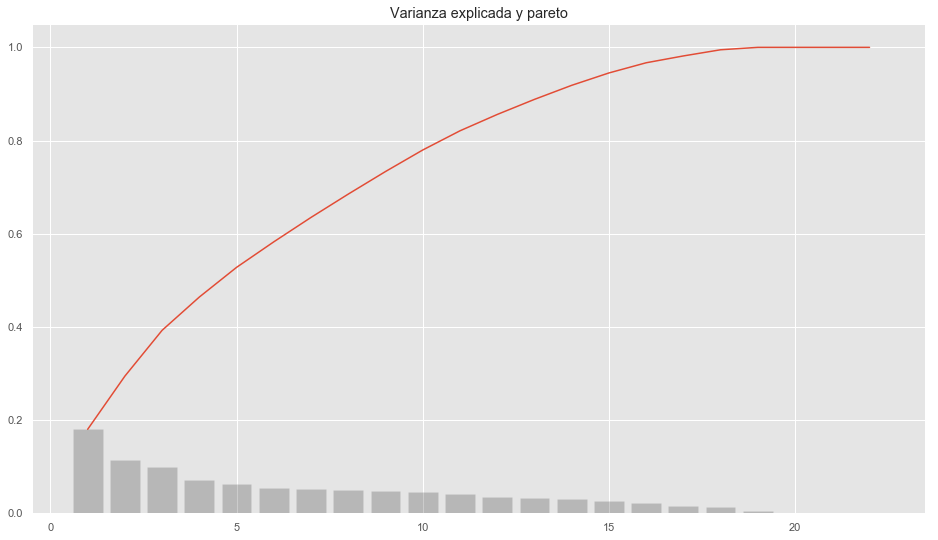

In [ ]:
for i in range(len(pca.components_)):
    print('% Var. explicada ('+str(i+1)+' componentes): ', np.cumsum(pca.explained_variance_ratio_)[i]*100)

plt.bar(range(1,len(pca.components_)+1),pca.explained_variance_ratio_, alpha=.2,color='0')
plt.plot(range(1,len(pca.components_)+1),np.cumsum(pca.explained_variance_ratio_),alpha=4)
plt.title("Varianza explicada y pareto")
plt.show()

**Según gráfico de Pareto**, cada una de las variables aportan porcentaje de varianza o información relevante para nuestro estudio. Esto lo que nos pudiera indicar es que no existe alguna relación fuerte entre las variables y no queda claro a simple vista con cuantas componentes trabajar.

**Según % Var. explicada**, se observa que cada una de las componentes tienen un importante porcentaje de varianza explicada, por lo que para nuestro PCA trabajaremos con 12 componentes ya que a partir de esta se ve que el incremento en la varianza explicada se va disminuyendo.

In [ ]:
# Elegimos la componente adecuada:
pcaFin = PCA(n_components=12)
pcaFin.fit(dataFrame[rubroName])

# Para mostrar todos los campos del Data frame:
pd.set_option('display.max_columns', None)

# Valor absoluto:
abs(pd.DataFrame(pcaFin.components_,columns=rubroName))

,prodsuper,restbar,salud,vehrep,entretenimiento,tiendadepar,ropamoda,prodpersondiv,telcom,financiero,transplaerea,clubmkt,prodlocal,enseñanza,belleza,prodelectro,alqbienes,artcultura,profdiverso,hogaroficina,informatica,**
0,0.323629,0.492083,0.239510,0.062491,0.051649,0.407144,0.522022,0.189349,0.108043,0.025381,0.014395,0.017428,0.107155,0.048053,0.075225,0.262999,0.097344,0.035121,0.053835,1.417204e-32,7.086022e-33,7.086022e-33
1,0.129182,0.203518,0.116963,0.022459,0.022004,0.036539,0.109284,0.006362,0.015230,0.011382,0.005030,0.012899,0.031705,0.008872,0.022321,0.954436,0.023944,0.009289,0.012744,2.387537e-33,1.193768e-33,1.193768e-33
2,0.307900,0.497869,0.156840,0.112854,0.045591,0.091043,0.765463,0.001757,0.068724,0.010360,0.002022,0.012869,0.083928,0.007836,0.006014,0.083311,0.062615,0.003560,0.025868,6.547567e-33,3.273783e-33,3.273783e-33
3,0.131011,0.159317,0.188360,0.021642,0.027009,0.877909,0.325879,0.092572,0.002979,0.000507,0.012873,0.014206,0.004723,0.044850,0.032294,0.084326,0.156488,0.014639,0.004235,7.338518e-31,3.669259e-31,3.669259e-31
4,0.604109,0.376133,0.318257,0.000042,0.087817,0.016012,0.000014,0.008395,0.050328,0.004175,0.015034,0.021673,0.052751,0.044481,0.023905,0.019342,0.608098,0.005200,0.074081,6.800450e-30,3.400225e-30,3.400225e-30
5,0.207654,0.466123,0.394876,0.009718,0.055613,0.100154,0.107597,0.166898,0.138550,0.006582,0.010291,0.018312,0.014399,0.052149,0.023751,0.012750,0.709501,0.006240,0.065329,5.958283e-27,2.979141e-27,2.979141e-27
6,0.524876,0.125117,0.621781,0.051177,0.013360,0.019224,0.059150,0.261406,0.407170,0.013962,0.006388,0.008941,0.052355,0.104531,0.045301,0.025110,0.254489,0.002406,0.003991,1.596084e-26,7.980422e-27,7.980422e-27
7,0.227318,0.135742,0.344093,0.084794,0.005979,0.027625,0.045150,0.043391,0.883231,0.019153,0.000062,0.028074,0.028691,0.113672,0.012906,0.038679,0.045796,0.006334,0.028162,1.366817e-25,6.834084e-26,6.834084e-26
8,0.132885,0.073977,0.213094,0.042625,0.038755,0.137771,0.030839,0.402674,0.028108,0.028759,0.003094,0.009840,0.008248,0.860340,0.049288,0.024332,0.001898,0.019457,0.026148,3.051789e-25,1.525894e-25,1.525894e-25
9,0.003995,0.029845,0.217018,0.180040,0.004996,0.138391,0.021545,0.809025,0.105041,0.035170,0.004226,0.021594,0.009736,0.467909,0.009353,0.049375,0.089390,0.006128,0.055469,5.149648e-24,2.574824e-24,2.574824e-24


Se observa que para cada componente hay una variable asignada según sus valores los que nos demuestra que para este caso no es necesario realizar reducción de dimencionalidad en nuetro estudio.

In [ ]:
rubroNameComp = ['ArteCultura','Productoselectrónicos','Osio','Tiendepart','Supermercados','AlquiBienes','Salud','telecomunicaciones','EstuAcad','JoyReAccesorios','SeguRepueVehículos','CuidEntretenimiento']
dataFrame[rubroNameComp]=pd.DataFrame(pcaFin.fit_transform(dataFrame[rubroName]),columns=rubroNameComp)
dataFrame[rubroNameComp].head(12)

grupoGiro,ArteCultura,Productoselectrónicos,Osio,Tiendepart,Supermercados,AlquiBienes,Salud,telecomunicaciones,EstuAcad,JoyReAccesorios,SeguRepueVehículos,CuidEntretenimiento
0,0.555637,1.665667,0.325976,0.044912,-0.167837,0.095937,-0.147219,0.669464,-0.274128,-0.204907,0.008620,-0.109886
1,-0.323281,-0.040747,0.065155,-0.042534,0.049697,-0.095698,0.024424,-0.061502,-0.024132,0.009677,-0.067243,-0.042525
2,0.440833,-0.300894,0.670312,0.066305,0.042261,-0.180442,-0.145895,-0.215602,-0.145003,0.071303,1.141992,-0.463956
3,-0.367925,-0.018233,0.027290,-0.022497,0.106810,-0.112479,-0.036796,-0.059767,-0.052930,-0.009561,-0.069537,-0.004757
4,-0.036744,-0.138311,0.218725,-0.467731,0.866137,1.713912,0.002310,0.144754,-0.197894,-0.362338,-0.065784,-0.241196
5,1.368795,1.612361,0.279156,1.027145,1.276416,1.772291,0.233460,-0.325991,0.261229,0.613866,-0.034089,0.424805
6,0.583742,-0.179449,-0.938955,-0.032243,0.005159,0.122629,-0.307349,0.039231,0.170661,0.412294,-0.038539,0.407954
7,-0.462356,0.021072,-0.069425,0.012555,0.028319,-0.017982,-0.017087,-0.035980,-0.033351,-0.002695,-0.041437,0.005886
8,-0.429852,0.007976,-0.036510,-0.003792,-0.039500,0.002694,0.040699,-0.060524,-0.019524,-0.003847,-0.052505,0.008250
9,1.644734,-0.735484,0.493034,-0.992841,-0.793410,-0.061718,0.350323,-0.407237,-0.098126,-0.158501,0.114015,-0.247754


#### 3.6 Modelamiento

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import pairwise_distances_argmin_min

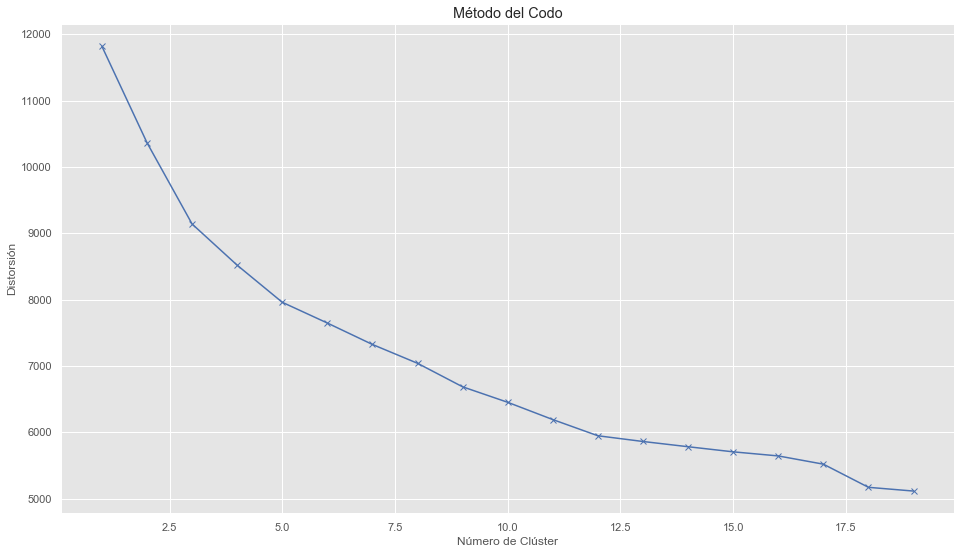

In [ ]:
#calcular la distorsión para un rango de número de clúster
X = dataFrame[rubroName]
distortions = []
for i in range(1, 20):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=600,
        tol=1e-04, random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 20), distortions, 'bx-')
plt.xlabel('Número de Clúster')
plt.ylabel('Distorsión')
plt.title('Método del Codo')
plt.show()

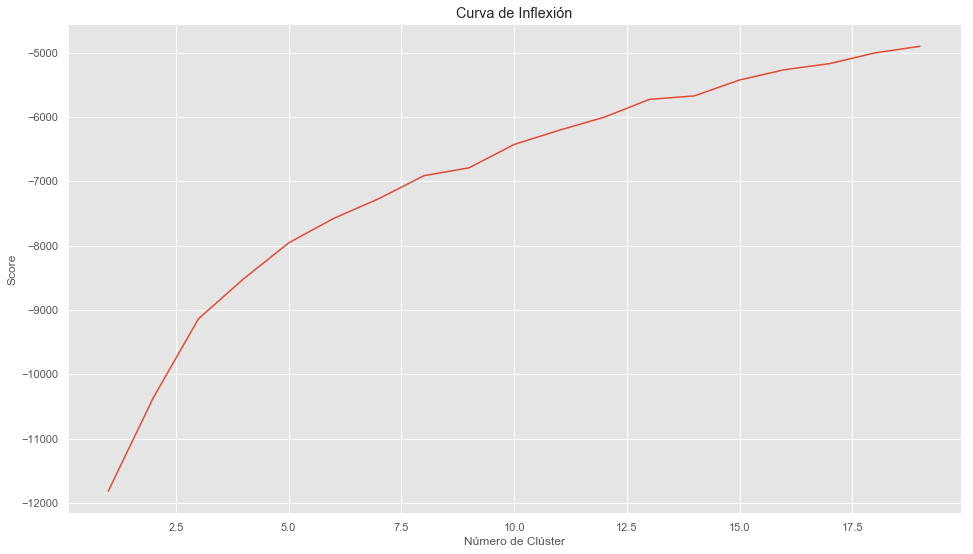

In [ ]:
# Calculando el número de clúster adecuado:
X = dataFrame[rubroName]

numClus = range(1, 20)
kmeans = [KMeans(n_clusters=i,max_iter=600, algorithm = 'auto') for i in numClus]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
plt.plot(numClus,score)
plt.xlabel('Número de Clúster')
plt.ylabel('Score')
plt.title('Curva de Inflexión')
plt.show()

La curva es bastante suave. Pudiéramos considerar un K de 10 según nuestro criterio.

In [ ]:
# Nos fijamos de los indicadores de clustering:
ctdDf = int(0.1*dataFrame.shape[0])
cluster = [kmeans[i].predict(X) for i in range(len(kmeans))]

for i in range(1,10):
    print(str(i+1)+' clústeres:')
    print('Inercia: '+str(kmeans[i].inertia_))
    print('Silueta: '+str(metrics.silhouette_score(X, cluster[i], metric='euclidean',sample_size=ctdDf)))
    print("\n")

2 clústeres:
Inercia: 10364.11946594351
Silueta: 0.4378399733529471


3 clústeres:
Inercia: 9139.014102732908
Silueta: 0.4180439846989957


4 clústeres:
Inercia: 8518.209785801339
Silueta: 0.37093218604263856


5 clústeres:
Inercia: 7959.325558625332
Silueta: 0.3956727902511506


6 clústeres:
Inercia: 7577.772953839065
Silueta: 0.32166386654553863


7 clústeres:
Inercia: 7270.991522499778
Silueta: 0.3381598670172985


8 clústeres:
Inercia: 6914.562462227545
Silueta: 0.3219044383717109


9 clústeres:
Inercia: 6792.029378844104
Silueta: 0.250312105559207


10 clústeres:
Inercia: 6429.205446329273
Silueta: 0.3008444713986483




Observando los valores de inercia y silueta consideraremos trabajar con los k = 3, 4 y 5 pero primero visualizaremos los grupos en 2-D para tener alguna noción de cómo se agrupan, en esta ocasión probaremos distintos pares de variables ya que se tienen 21 rubros en este estudio.

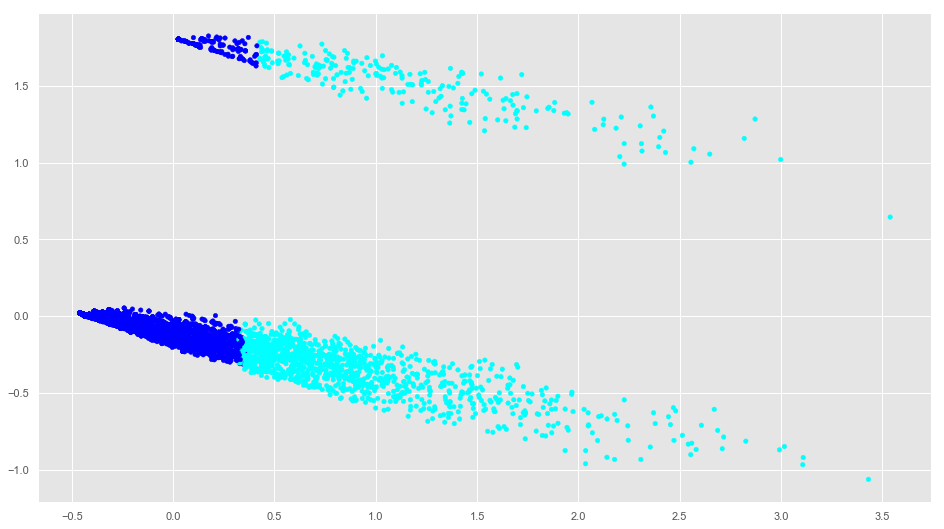

In [ ]:
#'ArteCultura','Productoselectrónicos',
fig = plt.figure()
f1 = dataFrame['ArteCultura'].values
f2 = dataFrame['Productoselectrónicos'].values

colores=['blue','cyan','yellow']
asignar=[]
for row in cluster[1]:
    asignar.append(colores[row])

plt.scatter(f1, f2, c=asignar, s=20)
plt.show()

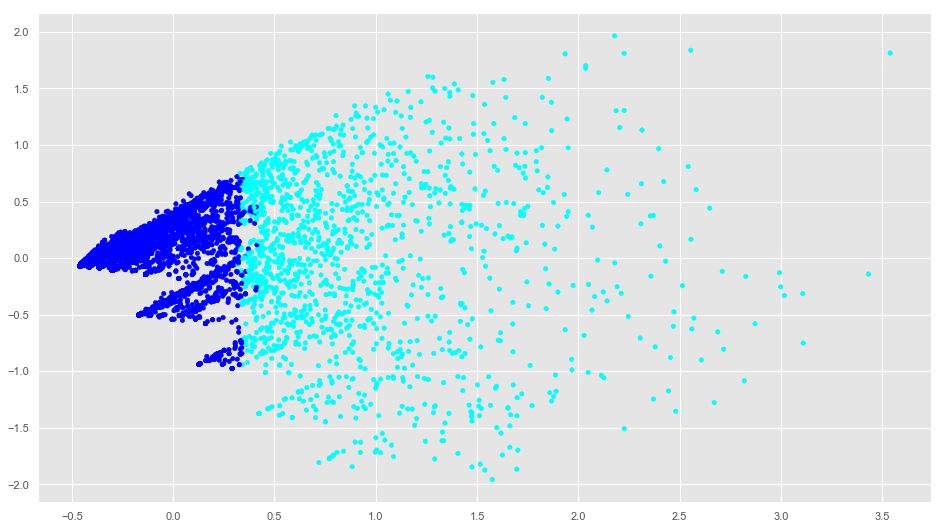

In [ ]:
# 'ArteCultura','Osio'
fig = plt.figure()
f1 = dataFrame['ArteCultura'].values
f2 = dataFrame['Osio'].values

colores=['blue','cyan','yellow']
asignar=[]
for row in cluster[1]:
    asignar.append(colores[row])

plt.scatter(f1, f2, c=asignar, s=20)
plt.show()

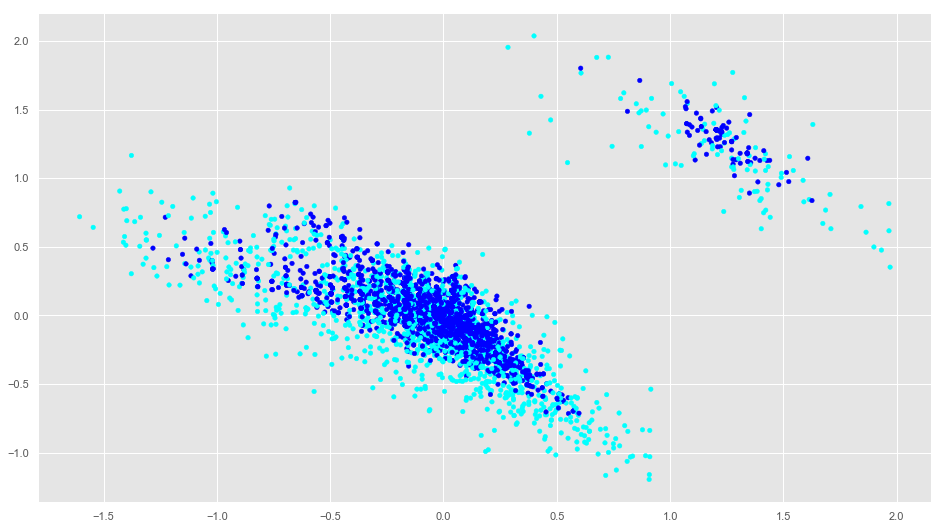

In [ ]:
# 'Supermercados,'AlquiBienes'
fig = plt.figure()
f1 = dataFrame['Supermercados'].values
f2 = dataFrame['AlquiBienes'].values

colores=['blue','cyan','yellow']
asignar=[]
for row in cluster[1]:
    asignar.append(colores[row])

plt.scatter(f1, f2, c=asignar, s=20)
plt.show()

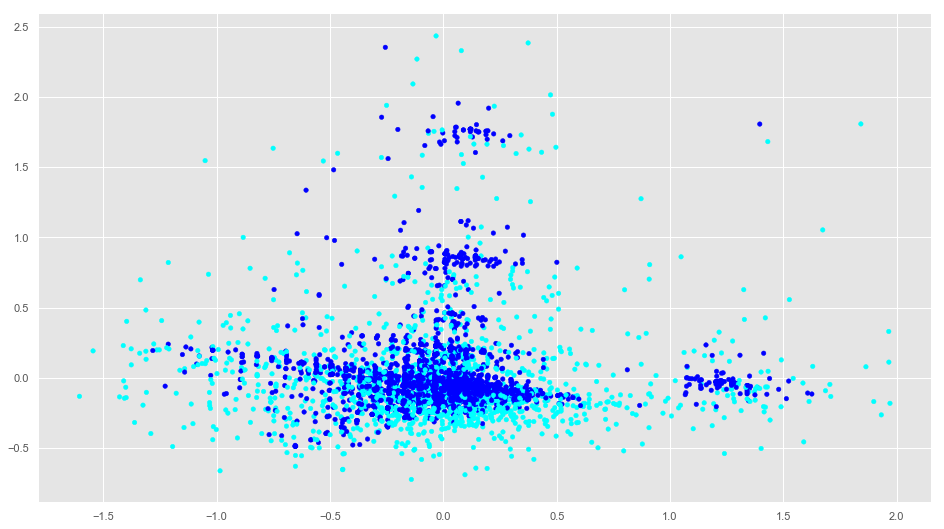

In [ ]:
# 'Supermercados,'EstuAcad',
fig = plt.figure()
f1 = dataFrame['Supermercados'].values
f2 = dataFrame['EstuAcad'].values

colores=['blue','cyan','yellow']
asignar=[]
for row in cluster[1]:
    asignar.append(colores[row])

plt.scatter(f1, f2, c=asignar, s=20)
plt.show()

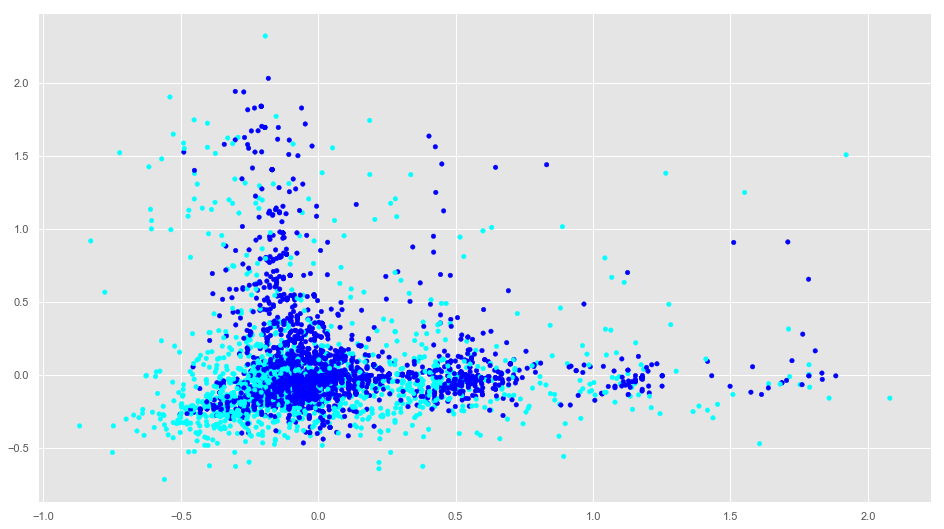

In [ ]:
# 'telecomunicaciones','SeguRepueVehículos'
fig = plt.figure()
f1 = dataFrame['telecomunicaciones'].values
f2 = dataFrame['SeguRepueVehículos'].values

colores=['blue','cyan','yellow']
asignar=[]
for row in cluster[1]:
    asignar.append(colores[row])

plt.scatter(f1, f2, c=asignar, s=20)
plt.show()

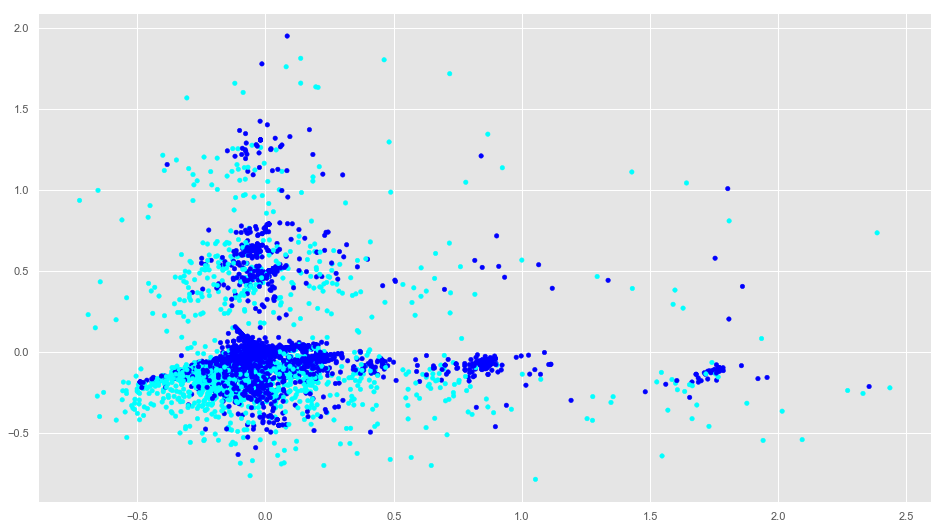

In [ ]:
# 'EstuAcad','CuidEntretenimiento'
fig = plt.figure()
f1 = dataFrame['EstuAcad'].values
f2 = dataFrame['CuidEntretenimiento'].values

colores=['blue','cyan','yellow']
asignar=[]
for row in cluster[1]:
    asignar.append(colores[row])

plt.scatter(f1, f2, c=asignar, s=20)
plt.show()

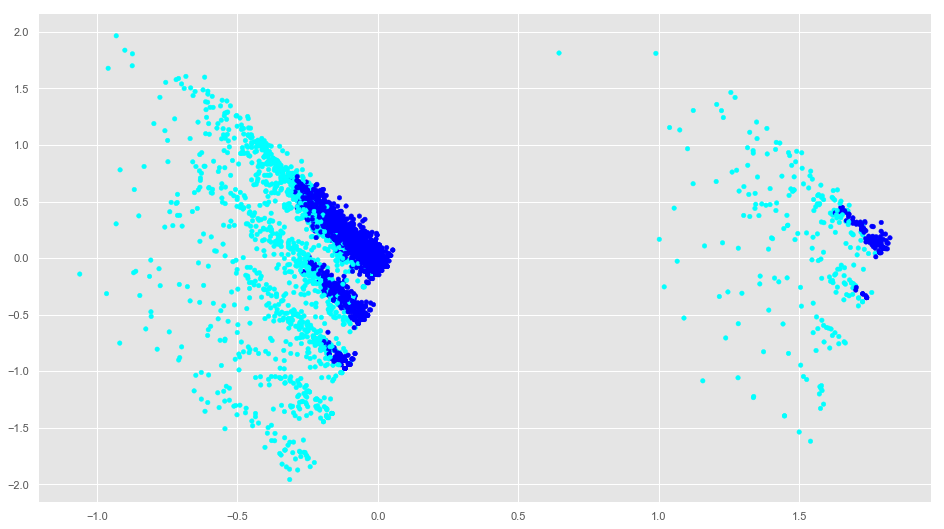

In [ ]:
# 'Productoselectrónicos','Osio'
fig = plt.figure()
f1 = dataFrame['Productoselectrónicos'].values
f2 = dataFrame['Osio'].values

colores=['blue','cyan','yellow']
asignar=[]
for row in cluster[1]:
    asignar.append(colores[row])

plt.scatter(f1, f2, c=asignar, s=20)
plt.show()

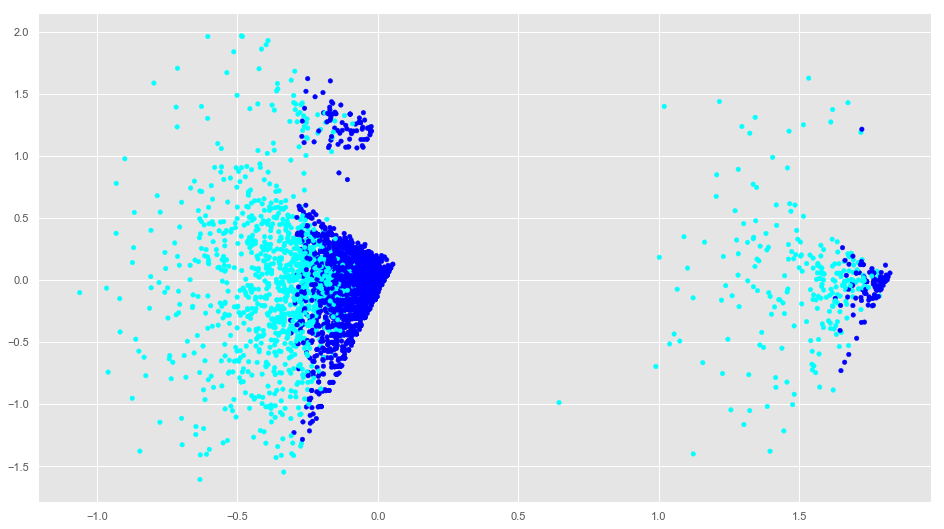

In [ ]:
# 'Productoselectrónicos','Supermercados'
fig = plt.figure()
f1 = dataFrame['Productoselectrónicos'].values
f2 = dataFrame['Supermercados'].values

colores=['blue','cyan','yellow']
asignar=[]
for row in cluster[1]:
    asignar.append(colores[row])

plt.scatter(f1, f2, c=asignar, s=20)
plt.show()

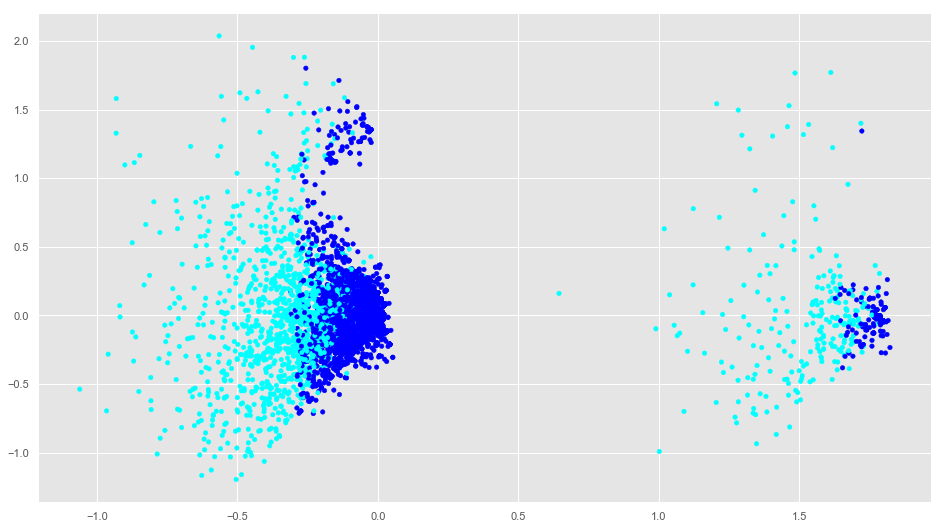

In [ ]:
# 'Productoselectrónicos','AlquiBienes'
fig = plt.figure()
f1 = dataFrame['Productoselectrónicos'].values
f2 = dataFrame['AlquiBienes'].values

colores=['blue','cyan','yellow']
asignar=[]
for row in cluster[1]:
    asignar.append(colores[row])

plt.scatter(f1, f2, c=asignar, s=20)
plt.show()

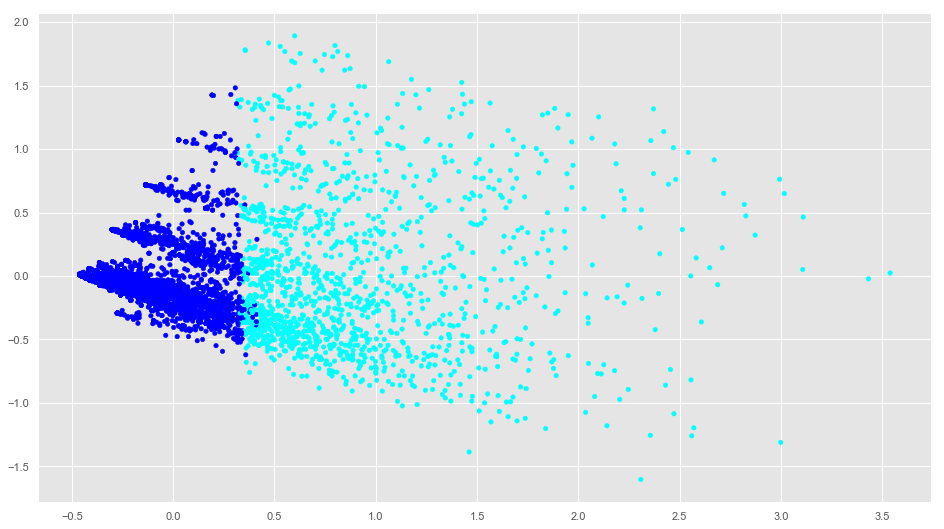

In [ ]:
#'ArteCultura','Tiendepart'
fig = plt.figure()
f1 = dataFrame['ArteCultura'].values
f2 = dataFrame['Tiendepart'].values

colores=['blue','cyan','yellow']
asignar=[]
for row in cluster[1]:
    asignar.append(colores[row])

plt.scatter(f1, f2, c=asignar, s=20)
plt.show()

#### 3.7 Evaluación

In [ ]:
numClus = [3,4,5,10]

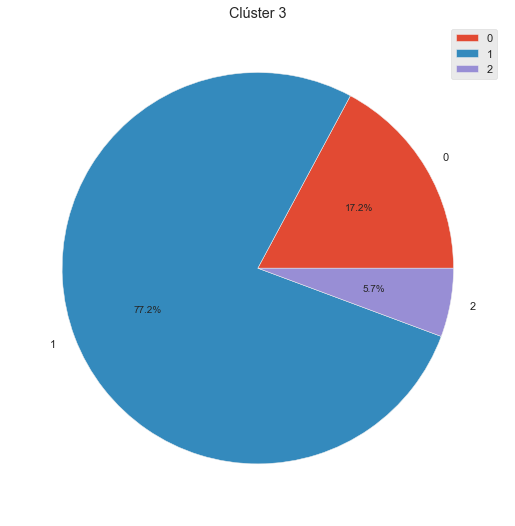

         ctdCliente  pctCliente
cluster                        
0              1284       17.16
1              5776       77.18
2               424        5.67




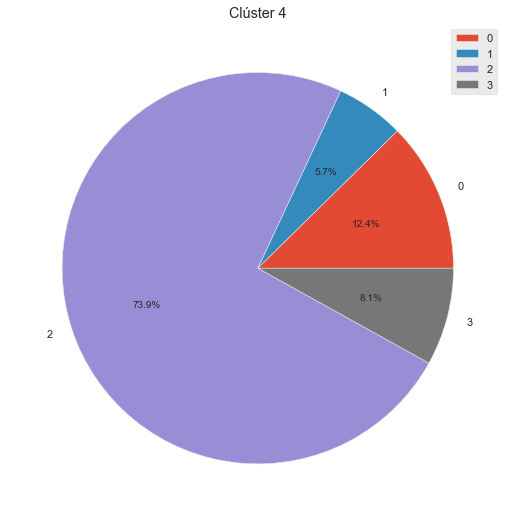

         ctdCliente  pctCliente
cluster                        
0               926       12.37
1               424        5.67
2              5531       73.90
3               603        8.06




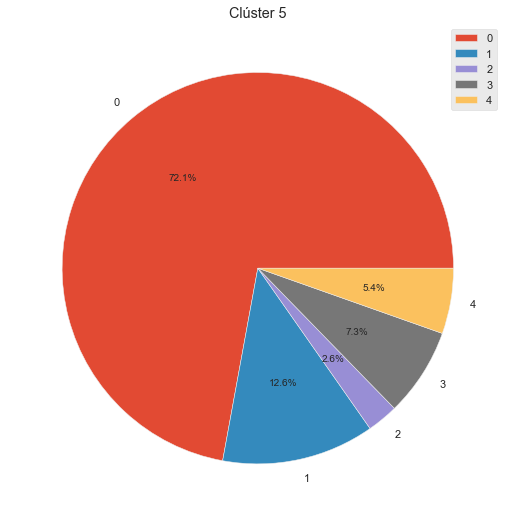

         ctdCliente  pctCliente
cluster                        
0              5398       72.13
1               943       12.60
2               192        2.57
3               546        7.30
4               405        5.41




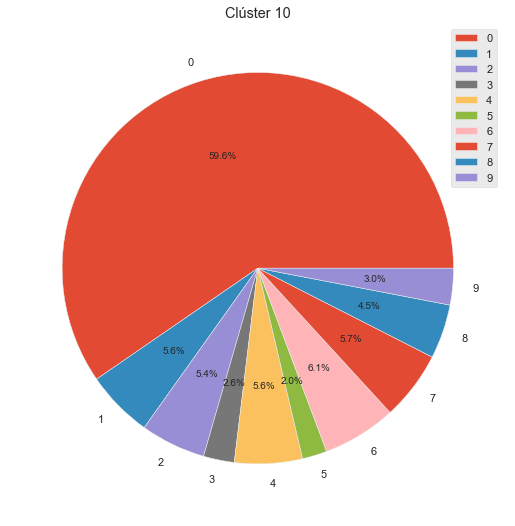

         ctdCliente  pctCliente
cluster                        
0              4460       59.59
1               415        5.55
2               403        5.38
3               191        2.55
4               419        5.60
5               153        2.04
6               456        6.09
7               426        5.69
8               335        4.48
9               226        3.02




In [ ]:
copy =  pd.DataFrame()
centroide = [kmeans[i].cluster_centers_ for i in range(len(kmeans))]
copy =  pd.DataFrame()

for i in numClus:
    # Distribución de los grupos por clúster:
    copy['cluster'] = cluster[i-1]

    cantidadGrupo =  pd.DataFrame()
    cantidadGrupo['ctdCliente']=copy.groupby('cluster').size()
    cantidadGrupo['pctCliente']=round(100*cantidadGrupo['ctdCliente']/cantidadGrupo['ctdCliente'].sum(),2)

    # gráfico de los grupos según su distribución:
    plt.pie(cantidadGrupo['pctCliente'], labels=cantidadGrupo.index, autopct='%1.1f%%')
    plt.title('Clúster '+ str(len(set(cluster[i-1]))))
    plt.legend()
    plt.show()
    print(cantidadGrupo)
    print('\n')

Según resultados podemos observar que:

**K = 3**, aunque no se puede ver la diversidad de rubros en cada uno de los grupos que se forman en este clúster es claro que el grupo_0 con 77.18% de los clientes nos indicaría la mayor concentración de rubros a diferencia del grupo_2 con 5.67% que sería lo contrario.

**K = 4**, En este caso al igual que el clúster de k= 3 se observa un grupo con gran diversidad de rubros representando el 73.90% de los clientes (grupo_1) y los grupos 1 y 3 con menor porcentaje 5.67% y 8.06% respectivamente.

**K = 5**, En este caso se observa que hay uno de los grupos grupo3 que es bastante pequeño con solo el 2.56% de los clientes.

Si bien en los tres valores de k seleccionados tienen grupos en donde se observa poca diversidad de rubros, el clúster que más consideramos idónea sería la de k = 4. También basándonos en sus valores de **Inercia: 8518.23 y Silueta: 0.42**


In [ ]:
numClusFinal = int(input('Ingrese el número de clúster: '))

Ingrese el número de clúster: 4


In [ ]:
# Pegamos los datos de los clústering:
dataFrame['cluster'] = cluster[numClusFinal-1]

In [ ]:
# calculamos los centroides de los clusteres:
copy = pd.DataFrame()
centroide = pd.DataFrame()

copy = dataFrame
for columnName in rubroNameComp:
    centroide[columnName] = copy.groupby('cluster').agg(columnName).mean()
centroide

,ArteCultura,Productoselectrónicos,Osio,Tiendepart,Supermercados,AlquiBienes,Salud,telecomunicaciones,EstuAcad,JoyReAccesorios,SeguRepueVehículos,CuidEntretenimiento
cluster,,,,,,,,,,,,
0,0.640157,-0.331453,0.531047,0.015350,-0.014349,-0.026810,0.030609,-0.025651,-0.002248,-0.004816,-0.007515,-0.010041
1,0.700064,1.627614,0.118140,-0.090024,-0.016085,-0.010818,-0.019055,-0.029834,-0.016042,-0.032220,0.001154,-0.001760
2,-0.250459,-0.039161,-0.010232,0.017206,0.001962,0.006993,-0.005649,0.006293,0.002095,0.001409,-0.000515,0.002998
3,0.822014,-0.276256,-0.804722,-0.118097,0.015347,-0.015367,0.018207,0.002649,-0.004481,0.017126,0.015450,-0.010846


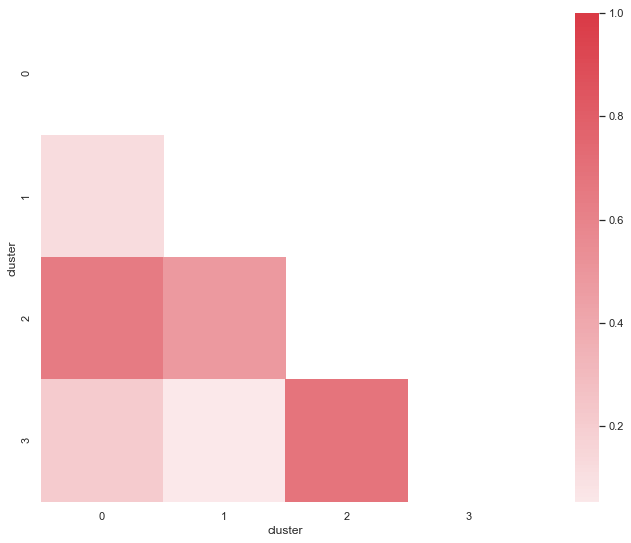

In [ ]:
dfTransp = centroide.T
corr = dfTransp.corr()

def plot_correlations(corr):
    sns.set(style="white")
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(abs(corr), mask=mask, cmap=cmap, vmax=1, center=0,square=True)

plot_correlations(corr)

En cuanto a las correlaciones se puede observar que el grupo 0 tiene una correlación positiva considerable con el grupo 2 y 1 y el grupo 2 con el grupo 3. Se pudiera considerar la rectificación de clúster a solo tres en vez de 4.  

##### Construimos nuestro Cluster Final

In [ ]:
clusFinal =  pd.DataFrame()
clusFinal['clusterFin'] = cluster[numClusFinal-1]

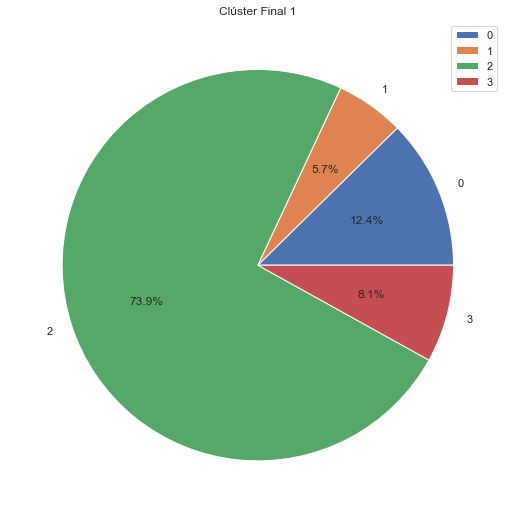

            ctdCliente  pctCliente
clusterFin                        
0                  926       12.37
1                  424        5.67
2                 5531       73.90
3                  603        8.06




In [ ]:
# Distribución de los grupos por clúster Final:
cantidadGrupo =  pd.DataFrame()
cantidadGrupo['ctdCliente']=clusFinal.groupby('clusterFin').size()
cantidadGrupo['pctCliente']=round(100*cantidadGrupo['ctdCliente']/cantidadGrupo['ctdCliente'].sum(),2)

# gráfico de los grupos según su distribución:
plt.pie(cantidadGrupo['pctCliente'], labels=cantidadGrupo.index, autopct='%1.1f%%')
plt.title('Clúster Final '+ str(len(set(clusFinal))))
plt.legend()
plt.show()
print(cantidadGrupo)
print('\n')

In [ ]:
# Pegamos la etiqueta Final
dataFrame['clusterFin'] = clusFinal

# calculamos los centroides de los clusteres:
copy = pd.DataFrame()
centroide = pd.DataFrame()

copy = dataFrame
for columnName in rubroNameComp:
    centroide[columnName] = copy.groupby('clusterFin').agg(columnName).mean()
centroide

,ArteCultura,Productoselectrónicos,Osio,Tiendepart,Supermercados,AlquiBienes,Salud,telecomunicaciones,EstuAcad,JoyReAccesorios,SeguRepueVehículos,CuidEntretenimiento
clusterFin,,,,,,,,,,,,
0,0.640157,-0.331453,0.531047,0.015350,-0.014349,-0.026810,0.030609,-0.025651,-0.002248,-0.004816,-0.007515,-0.010041
1,0.700064,1.627614,0.118140,-0.090024,-0.016085,-0.010818,-0.019055,-0.029834,-0.016042,-0.032220,0.001154,-0.001760
2,-0.250459,-0.039161,-0.010232,0.017206,0.001962,0.006993,-0.005649,0.006293,0.002095,0.001409,-0.000515,0.002998
3,0.822014,-0.276256,-0.804722,-0.118097,0.015347,-0.015367,0.018207,0.002649,-0.004481,0.017126,0.015450,-0.010846


Los Clúster estarian conformados:

**Clúster 0**,
**Clúster 1**,
**Clúster 2**,
**Clúster 3**,
**Clúster 4**,

#### 3.8 Perfilamiento

En esta sección veremos que rubros o sectores comerciales estarían conformados nuestros clusters finales, esto nos ayudaría a perfilar y dar un nombre. Pd. podría darnos mas información con otras variables (categóricas)

In [ ]:
import seaborn as sns

  ******************************
       GRUPOS DEL CLUSTER 4
  ******************************


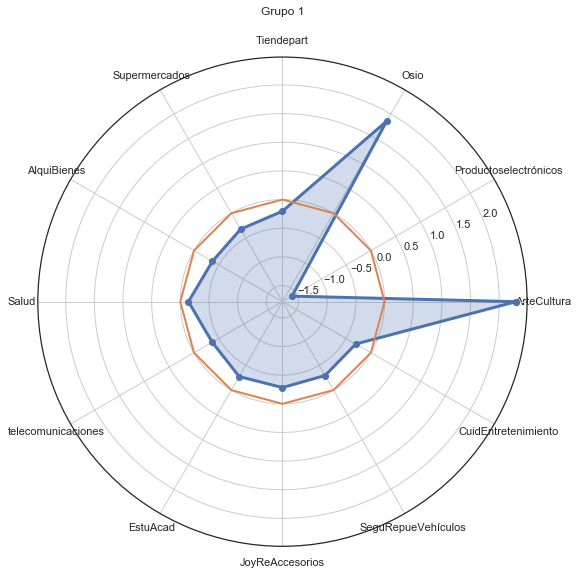

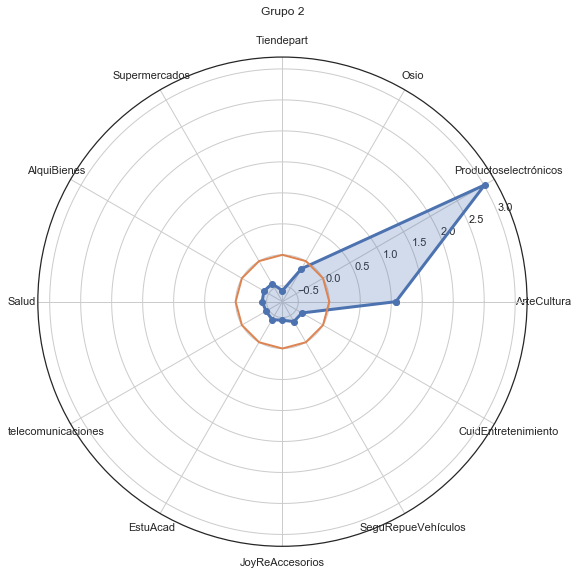

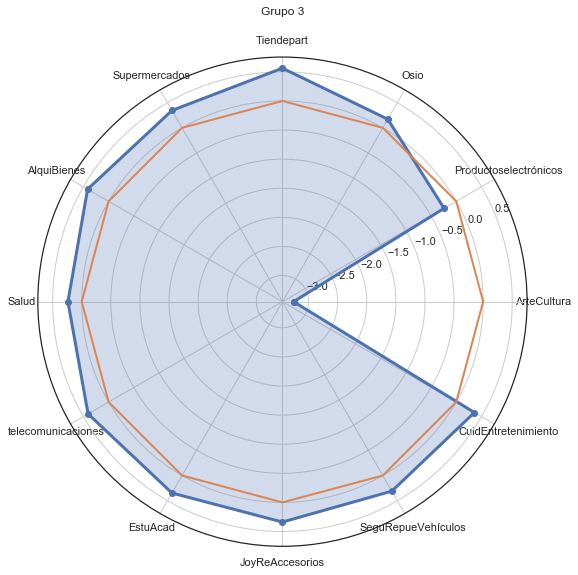

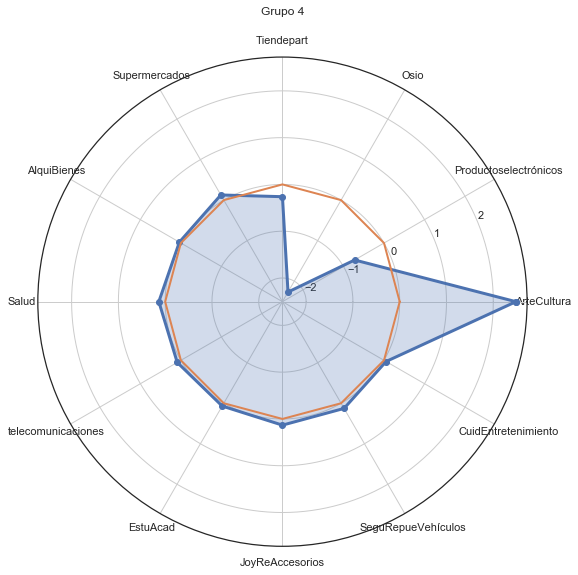

In [ ]:
print('  ******************************')
print('       GRUPOS DEL CLUSTER '+str(len(set(clusFinal['clusterFin']))))
print('  ******************************')

# Tener en cuenta el clúster con etiqueta "-1" que son los anómalos
for i in range(len(set(clusFinal['clusterFin']))):
    mu = centroide.loc[i].mean()
    dev= np.std(centroide.loc[i])

    stats=(centroide.loc[i].values-mu)/dev

    angles=np.linspace(0, 2*np.pi, len(rubroNameComp), endpoint=False)
    stats=np.concatenate((stats,[stats[0]]))
    ref = [0]*(len(rubroNameComp)+1)
    angles=np.concatenate((angles,[angles[0]]))

    fig=plt.figure()
    ax = fig.add_subplot(111, polar=True)
    ax.plot(angles, stats, 'o-', linewidth=3)
    ax.plot(angles, ref, '-', linewidth=2)

    ax.fill(angles, stats, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, rubroNameComp)
    ax.grid(True)
    ax.set_title('Grupo '+str(i+1)+'\n')



### Interpretación

**Grupo 1:**, En este grupo se puede observar que los clientes tienen mayor transaccionalidad promedio en los rubros de Arte y Cultura y Osio.

**Grupo 2:**, En este grupo podemos observar que está bien marcado por aquellos clientes que realizar más transacciones en el rubro de Producto electrónico y se observa una también un poco cercano de arte y cultura, teatro, librería, etc

**Grupo 3:**, Este es uno de los grupos con mayor diversidad en cuanto a rubros consumidos en promedio por los clientes, se pueden observar Osio, Tiendas por departamento, Supermercados, Alquiler de Bienes, Salud, Telecomunicaciones, Estudios Académicos, Accesorios y joyería, Seguros y repuestos para Vehículos y Cuidado y entretenimiento.

**Grupo 4:**, En este grupo la mayoría de los rubros se encuentra levemente por encima del promedio, pero el rubro que está muy por encima del promedio es Arte y Cultura. Se pudiera realizar un estudio con mayor profundidad para ver si este rubro se pudiera clasificar de mejor forma.


### Conclusiones

**1.-** En cuanto a la PCA, cada componente aporta información relevante, los que nos indica que no existe alguna relación fuerte entre variables y por lo que no sería necesario realizar este análisis para este conjunto de datos.

**2.-** En la curva de inflexión y Diagrama de codo no es tan evidente el número de clúster a utilizar, si bien al final utilizamos un k = 4, estos nos indicaron un K>= 10., por lo que este modelado su puede mejorar para dar mayor decepción en los resultados.

**3.-** El grupo 3 de mi clúster es el que concentra la mayor diversidad de rubros observándose en que todos están por encima del promedio: Osio, Tiendas por departamento, Supermercados, Alquiler de Bienes, Salud, Telecomunicaciones, Estudios Académicos, Accesorios y joyería, Seguros y repuestos para Vehículos y Cuidado y entretenimiento.

**4.-** Lo ideal es realizar un análisis exploratorio considerando estos grupos y las variables como sexo, edad e ingreso que nos permitan dar un mejor panorama y descripción de estos grupos de clientes según un perfilamiento más fino o preciso.
